# **EXERCÍCIO PROGRAMA 2.2**

## **Alunos:**  

*   Amanda Cristina Mazer - NUSP: 10200951
*   Carlos Alberto Silva de Souza - NUSP: 8539408
*   Leonardo Miranda de Brito - NUSP: 12630364


## **GitHub do projeto + dados:**

*   Link para o GitHub: https://github.com/Giganoide01/MAC5768_EPs
*   Link para a pasta do Google Drive: https://drive.google.com/drive/u/0/folders/1WEzT7nZTrtw9EBntSM8hCzoGQyDAQUIw


## Carregamento das bibliotecas ##

In [ ]:
import skimage
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import ndimage
from time import time
from skimage import io
from skimage.transform import resize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from google.colab import drive
import os

In [ ]:
t00 = time()

In [ ]:
#Coletor de lixo - otimiza a memória 
gc.enable()

## Pasta do Drive ##

In [ ]:
# Montando a pasta:
drive.mount('/content/gdrive')

# Alterando o diretório:
os.chdir('/content/gdrive/My Drive/MAC5768 - EPs/')

# Listando os arquivos do diretório:
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 Anel		    EP2-1.ipynb			        Livro
 augmentedDataset   EP2-2.ipynb			        MetaDadosc.xlsx
 Caneta		    Faca			        normalizedDataset
 Chave		    Fundo_gradiente		        originalGrayDataset
'Colher de pau'     Garfo			        Prato
 Copo		    Gradientes			        Tênis
 EP1.ipynb	   'Informações padronizadas EP.gdoc'


## Metadados ##

In [ ]:
# Tabela principal:
metadados = pd.read_excel('MetaDadosc.xlsx')
%load_ext google.colab.data_table

In [ ]:
#Tabela com as informações das classes
classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
classes

codigo      descricao abreviacao
0       1           Faca        fcs
1       2           Copo        cpo
2       3          Garfo        grf
3       4          Tênis        tns
4       5         Caneta        can
5       6          Livro        lvr
6       7  Colher de pau        cdp
7       8          Prato        prt
8       9          Chave        chv
9      10           Anel        ans

## 0. Importando filtros do EP2-1 ##

In [ ]:
def rgbparacinza(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem RGB e a transforma para uma imagem em níveis de cinza.
  Além disso, reduz as dimensões da imagem para metade das dimensões originais
  e retorna um numpy.ndarray com 8-bits por pixel, ou seja, do tipo np.uint8.

  Dependências: skimage, skimage.transform.resize, numpy as np
  '''

  # Converte para níveis de cinza:
  im_cinza = skimage.color.rgb2gray(imagem)

  # Aplica o resize - diminuindo para metade das dimensões originais:
  im_cinza = resize(im_cinza, output_shape = (im_cinza.shape[0]//2,im_cinza.shape[1]//2), anti_aliasing = False)

  # Muda o tipo de dado para np.uint8:
  im_cinza = skimage.util.img_as_ubyte(im_cinza)

  return im_cinza

In [ ]:
def soma_gradiente(imagem, fundo_gradiente):
  '''
  (numpy.ndarray,numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel e uma 
  imagem (fundo_gradiente) em   níveis de cinza com o tipo de dado numpy.float64
  no range(0,1). As duas imagens possuem a mesma dimensão.

  É retornada a soma das imagens por meio da operação:
  OUTPUT = IMAGEM*FUNDO_GRADIENTE

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage.
  '''

  # Realizando a 'soma': fundo_gradiente está no range (0,1):
  out = fundo_gradiente*imagem

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [ ]:
def logaritmo_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = LN(1+INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: skimage, numpy as np
  '''

  # Aplica a transformação logarítmica:
  out = skimage.exposure.adjust_log(imagem)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [ ]:
def exponencial_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = exp(INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, math
  '''

  # Aplica a função OUT = 255 * (exp(IN/255)-1)/(e-1):
  out = 255*(np.exp(imagem/255, dtype = np.float64)-1)/(math.e-1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [ ]:
def filtro_media(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o filtro da média da imagem de entrada usando convolução,
  uma janela de dimensões 9x9 e zero-padding.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Matriz de pesos ('weights'):
  k = np.full(shape = (9,9), fill_value = 1/81)

  # Aplica a convolução:
  out = ndimage.convolve(input = imagem, weights = k, mode = 'constant', cval = 0.0)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 0.1 Função base de normalização ##
A função de normalização utilizada foi a de equalização de histograma e baseia-se na função nativa do skimage, equalize_hist, cuja documentação pode ser acessada através do link: 
https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist


In [ ]:
def equalizar_vc(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada a imagem normalizada por meio da operação de equalização de histo-
  gramas.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Aplica a equalização de histograma:
  out = skimage.exposure.equalize_hist(imagem)*255

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 0.3 Algumas variáveis globais ##

In [ ]:
diretorio_final = '/content/gdrive/My Drive/MAC5768 - EPs/'

lista_extensoes = ['med','exp','log','grad']

todas_transf = ['cin', 'exp', 'log', 'med', 'grad', 'norm']

lista_filtros = [soma_gradiente, logaritmo_imagem, exponencial_imagem, filtro_media]

filtros = {rgbparacinza: 'cin', soma_gradiente: 'grad', logaritmo_imagem:'log',
           exponencial_imagem: 'exp', filtro_media:'med', equalizar_vc: 'norm'}

## 0.4 Importando funções gerais do EP2-1 ##

A função 'aplica_filtro' foi ligeiramente alterada para comportar a transformação de normalização.

In [ ]:
def cria_dataset(diretorio_original, tipo):
  ''' (str, str) -> None
  Essa função recebe duas strings: diretorio_original e tipo. Ela simplesmente
  cria uma pasta com o nome 'tipo' dentro de diretorio_original. Os valores que
  'tipo' irá receber são diversos: originalGrayDataset, augmentedDataset,
  normalizedDataset, os nomes das diferentes classes (Anel, Copo, etc) ou dos 
  filtros específicos (Exp, Log, Norm, Grad, Med).
  Dependência: os
  '''

  if not os.path.exists(diretorio_original + tipo):
    path = diretorio_original+tipo
    os.makedirs(path)
    

In [ ]:
def aplica_filtro(tipo_filtro , diretorio_original, diretorio_final, classe, dicionario_filtros = filtros, extensao_norm = 'cin'):
  ''' (function, str, str, str,dict, str) -> None.
  Essa função é o coração do EP. A mesma recebe uma função de filtro ('tipo_filtro')
  e aplica a mesma para todas as imagens da classe 'classe' que estiverem na 
  pasta 'diretorio_original' , escrevendo-as na pasta 'diretorio_final'. 

  No ato de aplicar os filtros, essa função utiliza o dicionário 'dicionario_filtros'
  para criar pastas com os nomes das transformações dentro das pastas das classes
  no 'diretorio_final', além de escrever as extensões corretas no nome final.

  No caso da transformação em níveis de cinza, não foi criada uma nova pasta nos
  diretórios de classes por ser considerada supérflua.

  No caso da função de normalização, é necessária a variável 'extensao_norm',
  que assume os valores 'cin', 'exp', 'med', 'log' ou 'grad'.

  Exemplo de aplicação 1:
  >>> aplica_filtro(tipo_filtro = rgbparacinza,
  diretorio_original = '/content/gdrive/MyDrive/MAC5768 - EPs/',
  diretorio_final = '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/Anel'
  #Aplica a transformação rgbparacinza em cada imagem com nome, por ex., 'exemplo.jpg'
  #Acessa a chave correspondente a rgbparacinza em dicionario_filtros (padrão: 'cin')
  #Escreve a imagem transformada na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/Anel'
  #Com o nome 'exemplo-cin.jpg'

  Exemplo de aplicação 2:
  >>> aplica_filtro(tipo_filtro = logaritmo_imagem,
  diretorio_original = '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/',
  diretorio_final = '/content/gdrive/MyDrive/MAC5768 - EPs/augmentedDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/Anel/'
  #Aplica a transformação logaritmo_imagem em cada imagem com nome, por ex., 'exemplo-cin.jpg'
  #Acessa a chave correspondente a logaritmo_imagem em dicionario_filtros (padrão: 'log')
  #Escreve a imagem transformada na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/augmentedDataset/Anel/log/'
  #Com o nome 'exemplo-cin-log.jpg'

  Dependências: gc, time.time, from pathlib import Path, skimage.io, os, skimage, random.choice
  '''

  # Correção para a entrada 'faca' em vez de 'Faca':
  classe = classe.capitalize()

  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()

  # Transformando a string do diretório de entrada em um objeto Path:
  if (tipo_filtro == equalizar_vc) and extensao_norm != 'cin':
    folder_entrada = Path(f"{diretorio_original}/")
  else:
    folder_entrada = Path(f"{diretorio_original}/{classe}/")

  # Extensão dos arquivos e nomes das novas pastas:
  extensao = dicionario_filtros[tipo_filtro]

  # Listando as imagens na pasta original:
  nomes_imagens = os.listdir(folder_entrada)

  # Criando e nomeando a nova pasta:
  if tipo_filtro == rgbparacinza:
    # Se a transformação for para níveis de cinza, não é necessário usar a extensão
    cria_dataset(diretorio_final, f"/{classe}")
    nova_pasta = Path(f"{diretorio_final}/{classe}/")

  elif tipo_filtro == equalizar_vc:
    # Se a transformação for de normalização, o folder de saída muda um pouco
    cria_dataset(diretorio_final, f"{classe}/{extensao_norm}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao_norm}/")

  else:
    cria_dataset(diretorio_final, f"{classe}/{extensao}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao}/")

  # Fazendo a lista das imagens gradiente, caso o filtro seja gradiente:
  if tipo_filtro == soma_gradiente:
    pasta_gradientes = Path("/content/gdrive/My Drive/MAC5768 - EPs/Gradientes/")
    # Lista o nome das imagens gradiente:
    nomes_gradientes = list(os.listdir(pasta_gradientes))

  for nome_imagem in nomes_imagens:
    # Lendo a imagem de entrada:
    imagem_entrada = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Aplicando o filtro:
    if tipo_filtro == soma_gradiente:

      # Escolhendo um fundo gradiente aleatório:
      gradiente = io.imread(f"{pasta_gradientes}/{choice(nomes_gradientes)}")
      # Ajustando o tamanho dele para a imagem de entrada:
      gradiente = skimage.transform.resize(gradiente, output_shape= imagem_entrada.shape)

      imagem_saida = tipo_filtro(imagem_entrada, gradiente)

    else:
      imagem_saida = tipo_filtro(imagem_entrada)

    # Escrevendo a imagem de saída no diretório correto com a extensão correta:
    os.chdir(nova_pasta)
    io.imsave(f"{nome_imagem[:-4]}-{extensao}.jpg", imagem_saida)

    del imagem_entrada, imagem_saida

  del nomes_imagens

  # Tempo para aplicação da função:
  t1 = time()
  print(f"Tempo para aplicação do filtro '{extensao}' para a pasta {folder_entrada}: {(t1-t0):.3f}s")

## 1. Criação do normalizedDataSet ##

Breve explicação do código: para a criação do normalizedDataSet, é necessário aplicar apenas uma função para cada uma das pastas do augmentedDataSet e do 
originalGrayDataset.


In [ ]:
# Criando a pasta do 'normalizedDataset':
cria_dataset(diretorio_final,'normalizedDataset' )

In [ ]:
# Aplicando a normalização para as imagens em níveis de cinza:
Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = equalizar_vc,
  diretorio_original = f"{diretorio_final}/originalGrayDataset/",
  diretorio_final = f"{diretorio_final}/normalizedDataset/",
  classe = classe,
  extensao_norm = 'cin') for classe in classes['descricao'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.7min finished


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
# Aplicando a normalização para as demais transformações:
for extensao in lista_extensoes:
  Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = equalizar_vc, diretorio_original = f"{diretorio_final}/augmentedDataset/{classe}/{extensao}", diretorio_final = f"{diretorio_final}/normalizedDataset/" , classe = classe, extensao_norm = extensao) for classe in classes['descricao'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.9min finished


## 2. Protótipo médio, histograma médio e variâncias no histograma médio de cada classe/transformação: código geral ##

Breve explicação do código: em relação ao protótipo médio, um vetor de zeros é iniciado e vão sendo somadas imagem por imagem, divididas pelo número de imagens na pasta que está sendo considerada no momento.

Em relação aos histogramas médios e variâncias em cada bin, foi criada uma matriz chamada 'todos_histogramas', em que cada linha armazena os valores das contagens de histograma para cada imagem e cada coluna representa um nível de cinza (de 0 a 255). Após isso, as funções np.mean e np.var foram aplicadas sobre as colunas, a fim de obter o histograma médio e a variância por nível de cinza.

A função 'prototipo_medio' calcula o protótipo médio, o histograma médio e a variância do histograma médio para uma pasta específica. A função 'aplica_protmed_classe' realiza essa tarefa para todas as transformações de determinada classe.

In [ ]:
def prototipos_medios(classe, tipo_transf, folder_pai = '/content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset', class_df = classes, extensao_norm = 'cin'):
  ''' (str, str, str, pandas.dataframe, str) -> numpy.ndarray , numpy.ndarray, numpy.ndarray
  Essa função recebe uma str classe, que contém o nome de determinada classe
  de objetos.
  Recebe, ainda, uma str tipo_transf, que contém as iniciais da transformação
  referente ao dataset original. A variável tipo_transf pode assumir os valores
  'cin', 'exp', 'log', 'med', 'grad' e 'norm'.

  Quando tipo_transf == 'norm', é necessária a variável 'extensao_norm',
  que assume os valores 'cin', 'exp', 'med', 'log' ou 'grad'.

  A variável folder_pai representa o diretório que contém as pastas das classes.

  Retorna-se o protótipo médio da classe 'classe' após aplicada a transformação
  'tipo_transf', o histograma médio da classe 'classe', representado por
  seus vetores de médias e variâncias.

  Dependências: gc, time.time, pathlib.Path, os, skimage, numpy as np, pandas,
  skimage.io, matplotlib.pyplot as plt
  '''

  classe = classe.capitalize()
  
  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()
  
  # Transformando a string em um objeto Path:
  if tipo_transf == 'norm':
    folder_entrada = Path(f"{folder_pai}/{classe}/{extensao_norm}")
  elif tipo_transf == 'cin':
    folder_entrada = Path(f"{folder_pai}/{classe}")
  else:
    folder_entrada = Path(f"{folder_pai}/{classe}/{tipo_transf}")
  
  nomes_imagens = os.listdir(folder_entrada)
  tamanho_folder = len(nomes_imagens)
  # Imagem-base para fazer o protótipo médio:
  sample_image = io.imread(f"{folder_entrada}/{nomes_imagens[0]}")
  prot_med = np.zeros(shape = sample_image.shape)
  del sample_image
  # Cada linha de 'todos_histogramas' é o histograma de uma imagem
  todos_histogramas = np.zeros(shape = (tamanho_folder, 256))
  for i in range(len(nomes_imagens)):
    nome_imagem = nomes_imagens[i]
    # Lendo a imagem em níveis de cinza:
    im_cinza = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Histograma da imagem em níveis de cinza:
    contagens, bins = np.histogram(im_cinza, bins=256)
    todos_histogramas[i,:] =  contagens

    # Protótipo médio:
    prot_med = np.add(prot_med,im_cinza/tamanho_folder)
       
    del im_cinza, bins, nome_imagem

  # Média e variância dos histogramas:
  medias = np.mean(todos_histogramas, axis = 0)
  variancias = np.var(todos_histogramas, axis = 0)
  
  del nomes_imagens, todos_histogramas
  t1 = time()
  print(f"Tempo de execução das estatísticas médias para a pasta {folder_entrada}: {(t1-t0):.3f}s")

  return np.array(prot_med, dtype = np.uint8), medias, variancias

In [ ]:
def aplica_protmedio_classe(classe, diretorio):
  ''' (str, str) -> list, list, list
  Essa função recebe uma str 'classe' e um diretorio 'diretorio' e retorna três
  listas: uma de protótipos médios, uma das médias dos histogramas médios e uma
  das variâncias dos histogramas médios para cada uma das 10 transformações.
  São elas, nessa ordem:
    1. Original em níveis de cinza
    2. Exponencial (aplicada a 1)
    3. Logaritmo (aplicada a 1)
    4. Filtro da média (aplicada a 1)
    5. Soma com fundo gradiente (aplicada a 1)
    6. Normalização (aplicada a 1)
    7. Normalização (aplicada a 2)
    8. Normalização (aplicada a 3)
    9. Normalização (aplicada a 4)
    10. Normalização (aplicada a 5).
  Dependências: gc, prothist, numpy as np
  '''

  # Coletor automático de lixo:
  gc.enable()

  # Calculando as estatísticas para o originalGrayDataset:
  estatisticas_gray = prototipos_medios(classe = classe, tipo_transf = 'cin' , folder_pai = f"{diretorio}/originalGrayDataset")
  # Calculando as estatísticas para o augmentedDataset:
  estatisticas_augmented = Parallel(n_jobs=-1, verbose = 1)(delayed(prototipos_medios)(classe = classe, tipo_transf = transf , folder_pai = f"{diretorio}/augmentedDataset") for transf in todas_transf[1:-1])
  # Calculando as estatísticas para todas as transformações do normalizedDataset:
  estatisticas_normalized = Parallel(n_jobs=-1, verbose = 1)(delayed(prototipos_medios)(classe = classe, tipo_transf = 'norm' , folder_pai = f"{diretorio}/normalizedDataset", extensao_norm = transf) for transf in todas_transf[:-1])

  # As listas seguintes armazenarão os valores finais dos protótipos médios,
  # médias dos histogramas médios e variãncias dos histogramas médios:
  lista_prot, lista_hist, lista_var = [],[],[]

  lista_prot.append(estatisticas_gray[0])
  lista_hist.append(estatisticas_gray[1])
  lista_var.append(estatisticas_gray[2])

  for transformacao in range(len(estatisticas_augmented)):
    lista_prot.append(estatisticas_augmented[transformacao][0])
    lista_hist.append(estatisticas_augmented[transformacao][1])
    lista_var.append(estatisticas_augmented[transformacao][2])
  
  for transformacao in range(len(estatisticas_normalized)):
    lista_prot.append(estatisticas_normalized[transformacao][0])
    lista_hist.append(estatisticas_normalized[transformacao][1])
    lista_var.append(estatisticas_normalized[transformacao][2])
  
  del estatisticas_gray, estatisticas_augmented, estatisticas_normalized

  return lista_prot, lista_hist, lista_var

In [ ]:
def grafico(lista_prototipos_medios, lista_histogramas_medios, lista_variancias_medias, x = np.arange(0,256)):
  '''
  (list, list,list, numpy.ndarray) -> None
  Essa função recebe três listas: uma de protótipos médios, uma das médias dos 
  histogramas médios e uma das variâncias dos histogramas médios para cada uma 
  das 10 transformações. Faz uma visualização conjunta 
  dos mesmos com o padrão MNIST e barras de erros.
  Dependências: matplotlib.pyplot as plt
  '''
  
  titulos = [ "Níveis de cinza", "Exponencial","Logaritmo", "Com gradiente", "Filtro da média"]
  metade = len(lista_histogramas_medios)//2
  lista_desvpad = []

  for i in range(len(lista_variancias_medias)):
    lista_desvpad.append(np.sqrt(lista_variancias_medias[i]))
  
  fig, axs = plt.subplots(10, 3, figsize=(25, 40))

  for i in range(10):
    axs[i,0].imshow(lista_prototipos_medios[i], cmap='gray',vmin=0, vmax=255)
    axs[i,0].axis('off')
    axs[i,1].bar(x = x, height = lista_histogramas_medios[i])
    axs[i,2].errorbar(x = x, y = lista_histogramas_medios[i], yerr = lista_desvpad[i])
    if i < metade:
      axs[i,0].set_title(f"{titulos[i]}: Protótipo médio")
      axs[i,1].set_title(f"{titulos[i]}: Histograma médio")
      axs[i,2].set_title(f"{titulos[i]}: Histograma médio com variâncias")
    else:
      axs[i,0].set_title(f"{titulos[i-metade]} Norm: Protótipo médio")
      axs[i,1].set_title(f"{titulos[i-metade]} Norm: Histograma médio")
      axs[i,2].set_title(f"{titulos[i-metade]} Norm: Histograma médio com variâncias")
  plt.show()
  plt.tight_layout()

## 3, 4 e 5. Protótipo médio, histograma médio e variâncias dos histogramas médios de cada classe ##

* Anel

In [ ]:
anel_prot, anel_hist, anel_var = aplica_protmedio_classe(classe = 'Anel', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Anel: 19.323s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   56.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


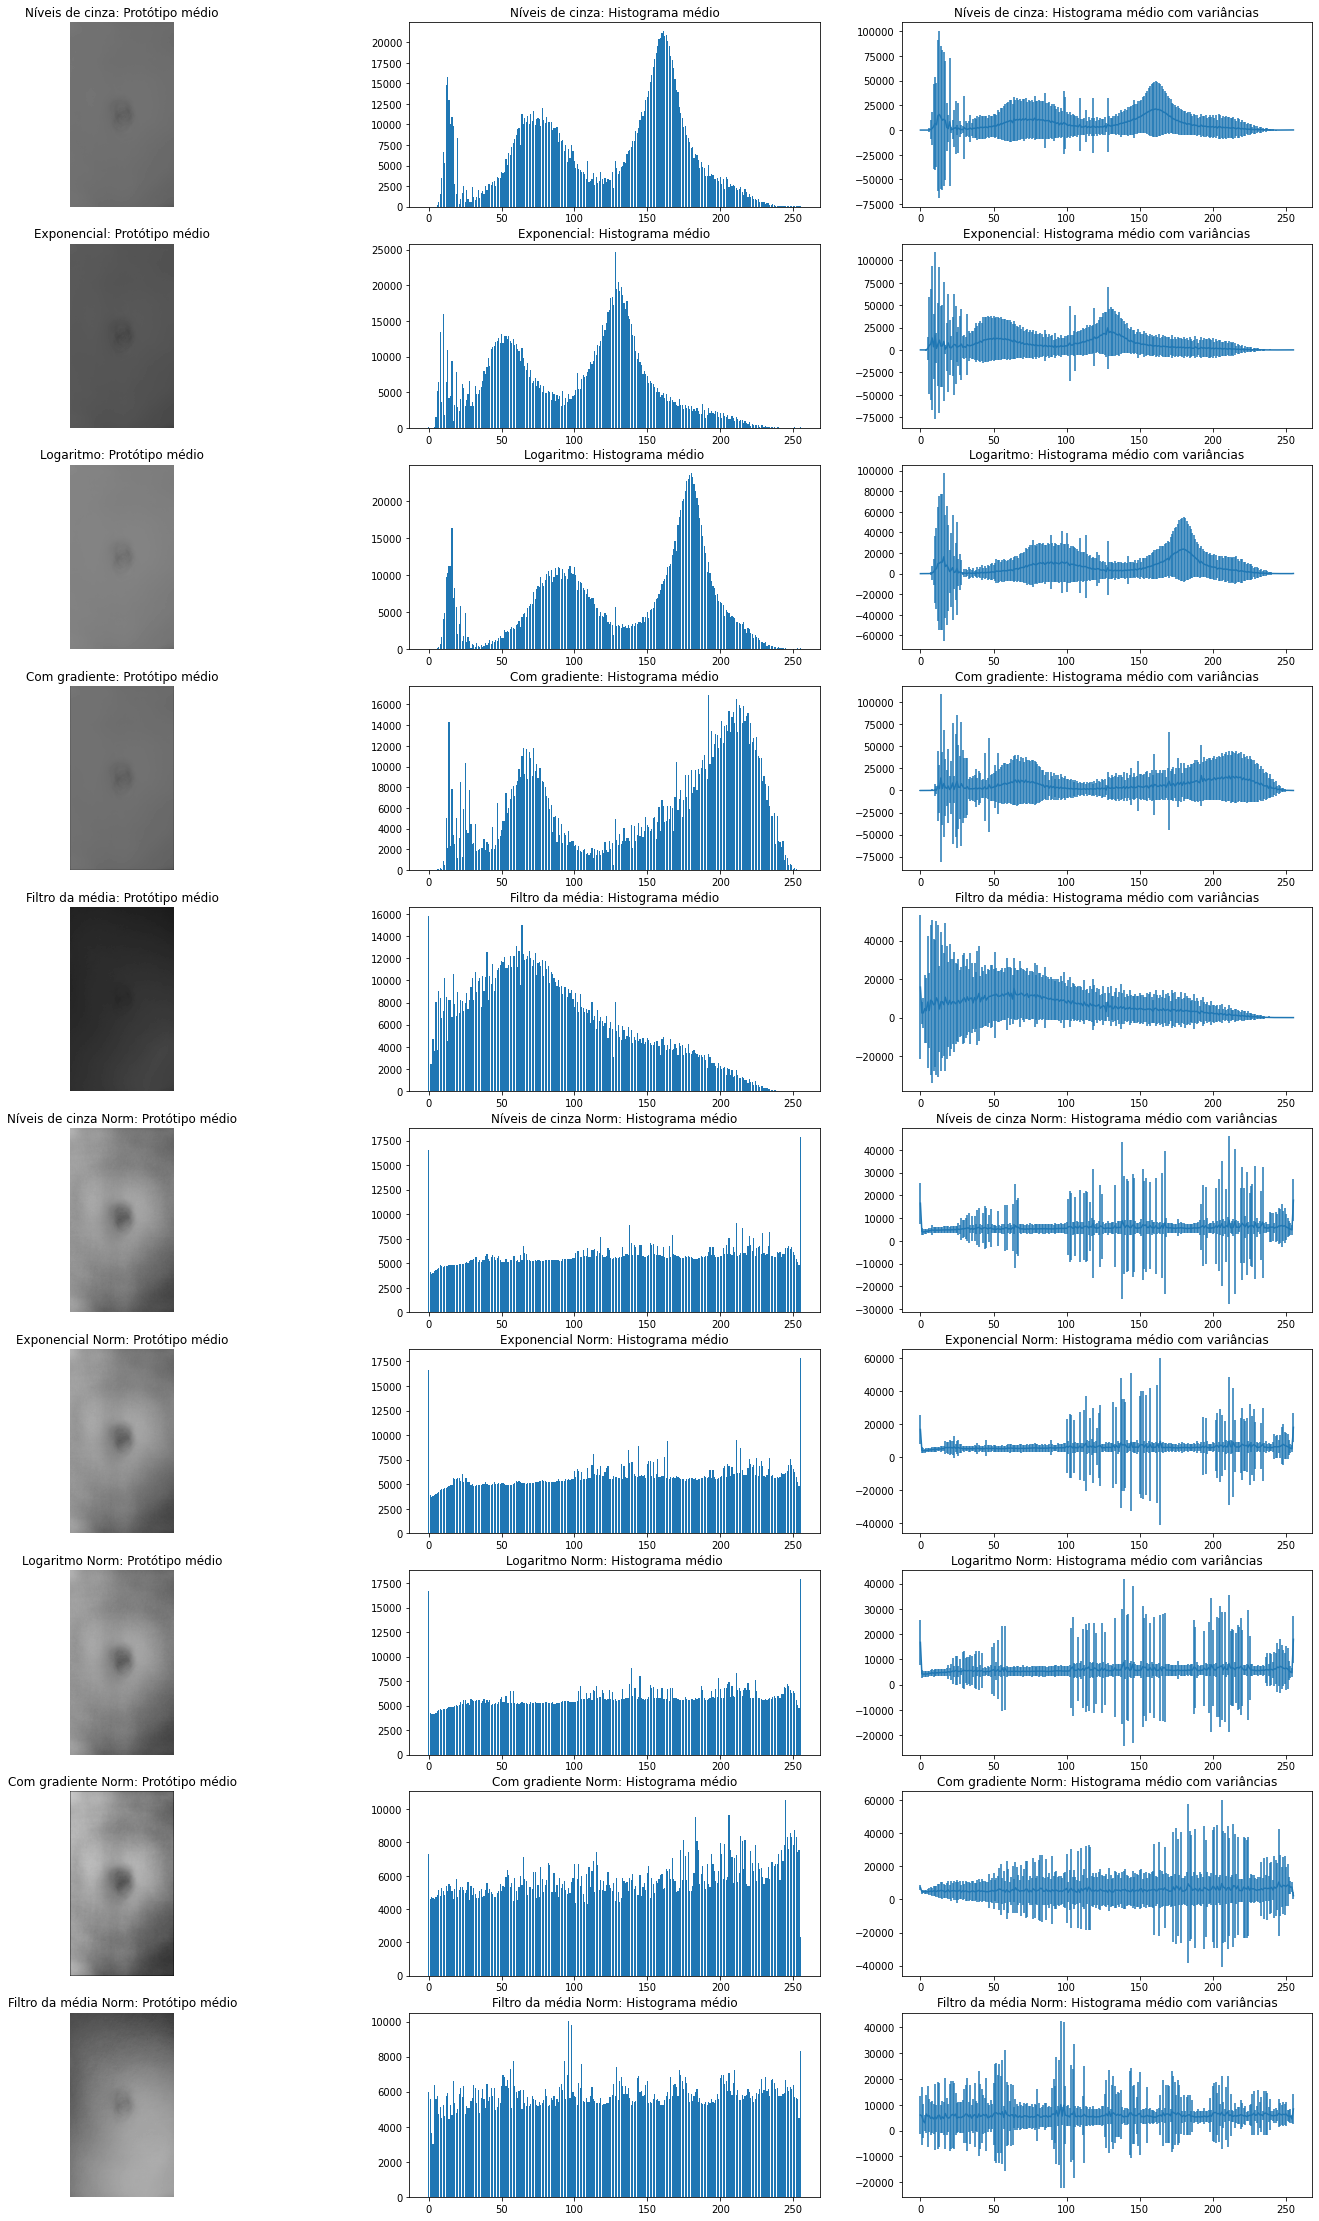

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(anel_prot, anel_hist, anel_var)

* Chave

In [ ]:
chave_prot, chave_hist, chave_var = aplica_protmedio_classe(classe = 'Chave', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Chave: 18.692s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


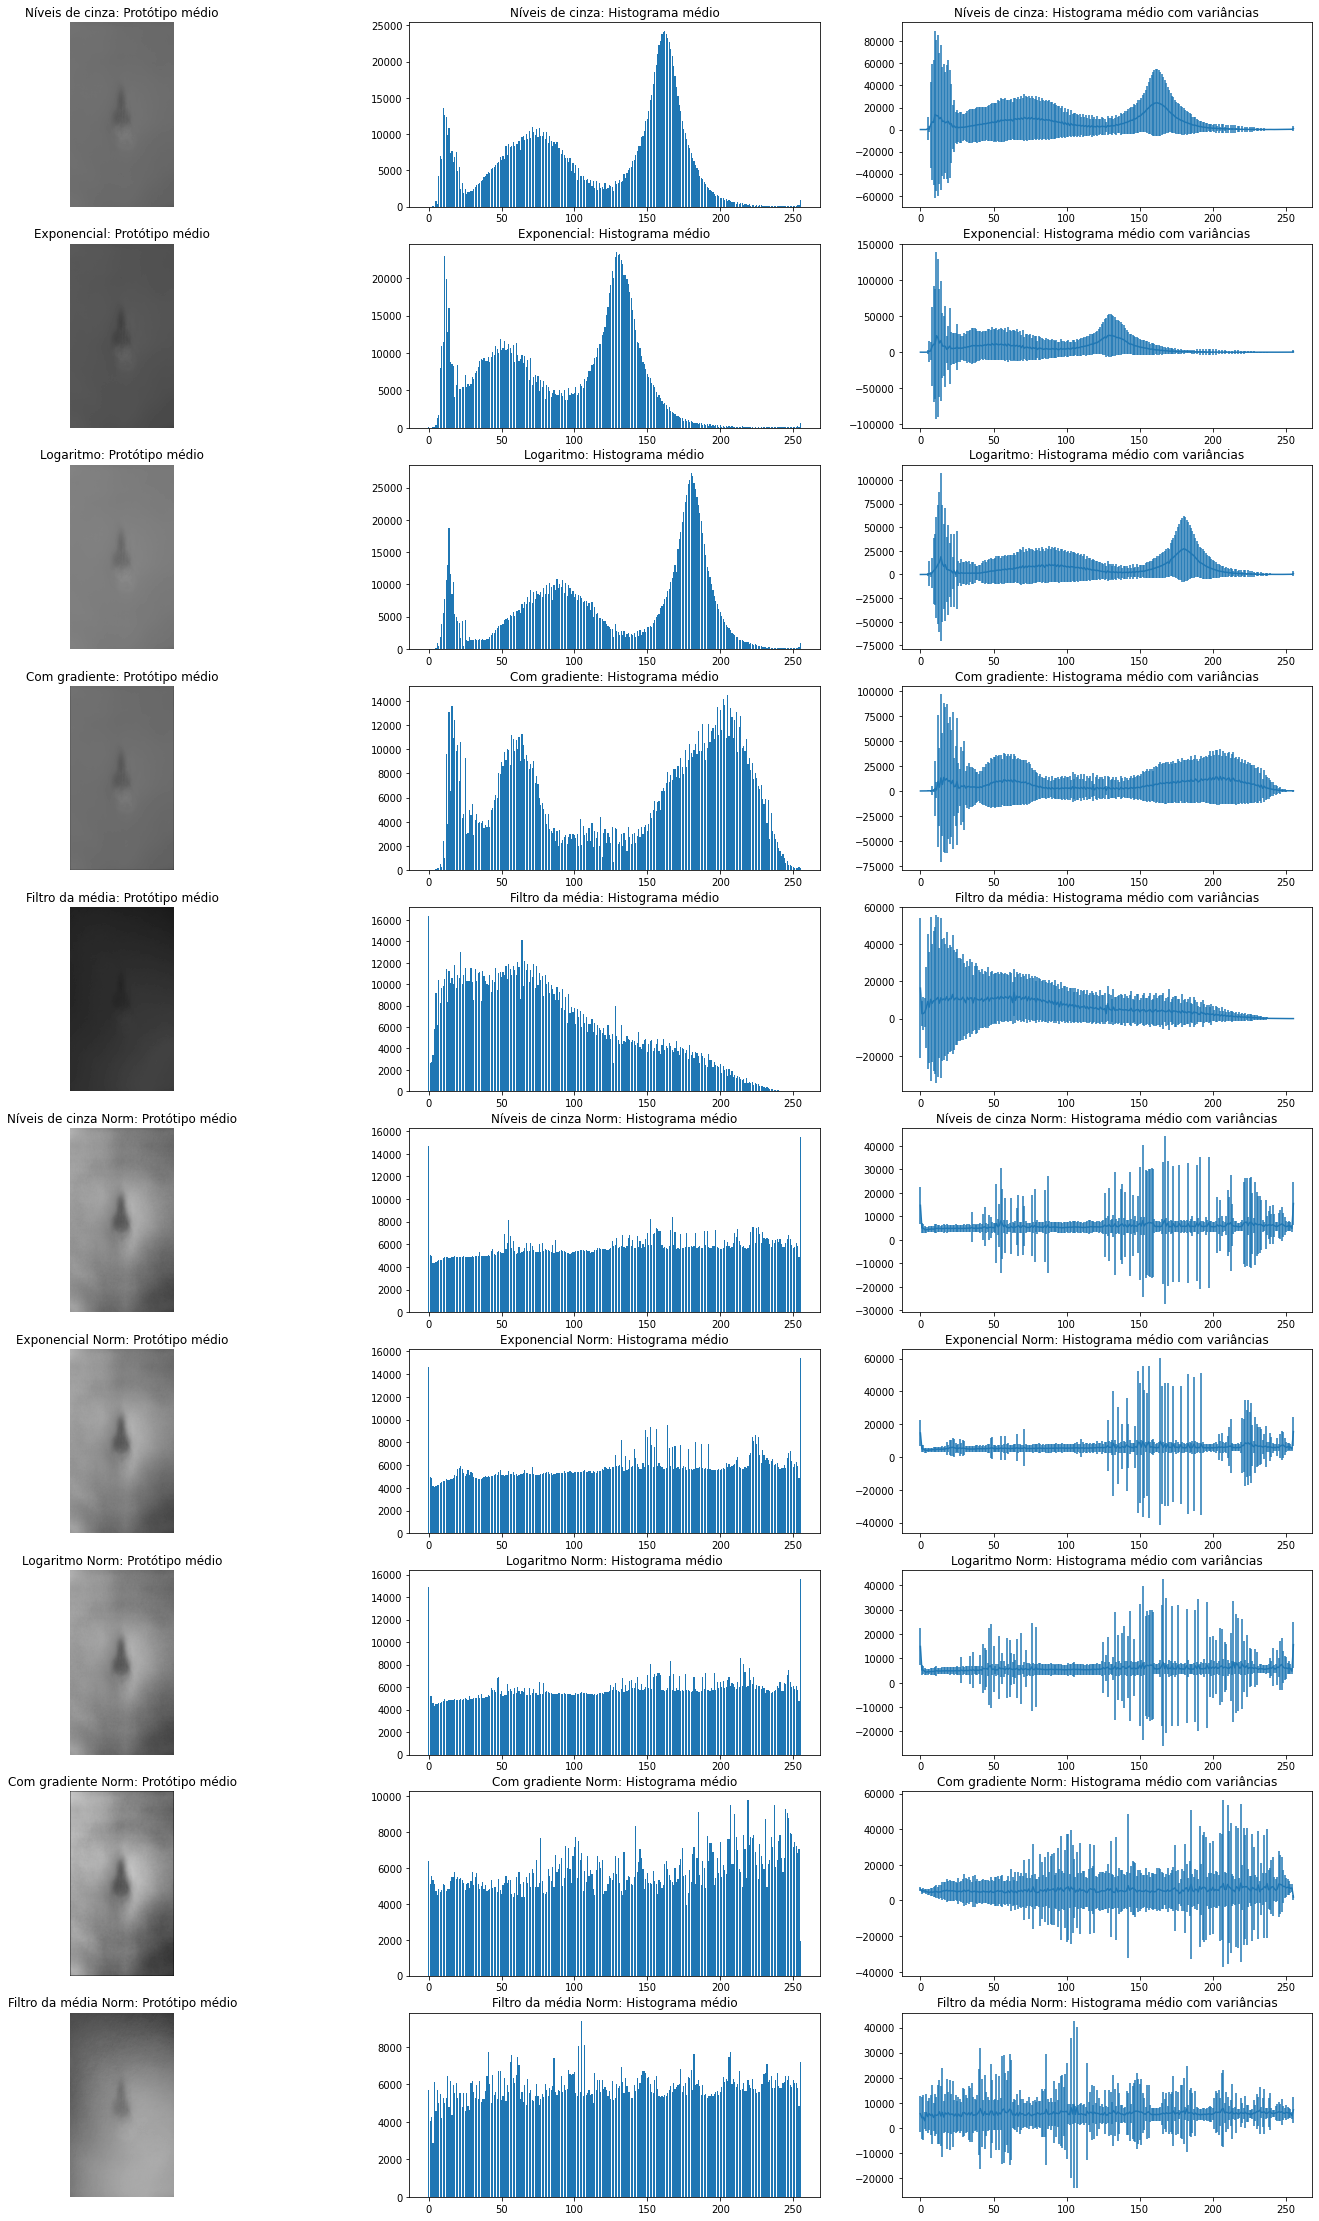

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(chave_prot, chave_hist, chave_var)

* Prato

In [ ]:
prato_prot, prato_hist, prato_var = aplica_protmedio_classe(classe = 'Prato', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Prato: 23.541s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


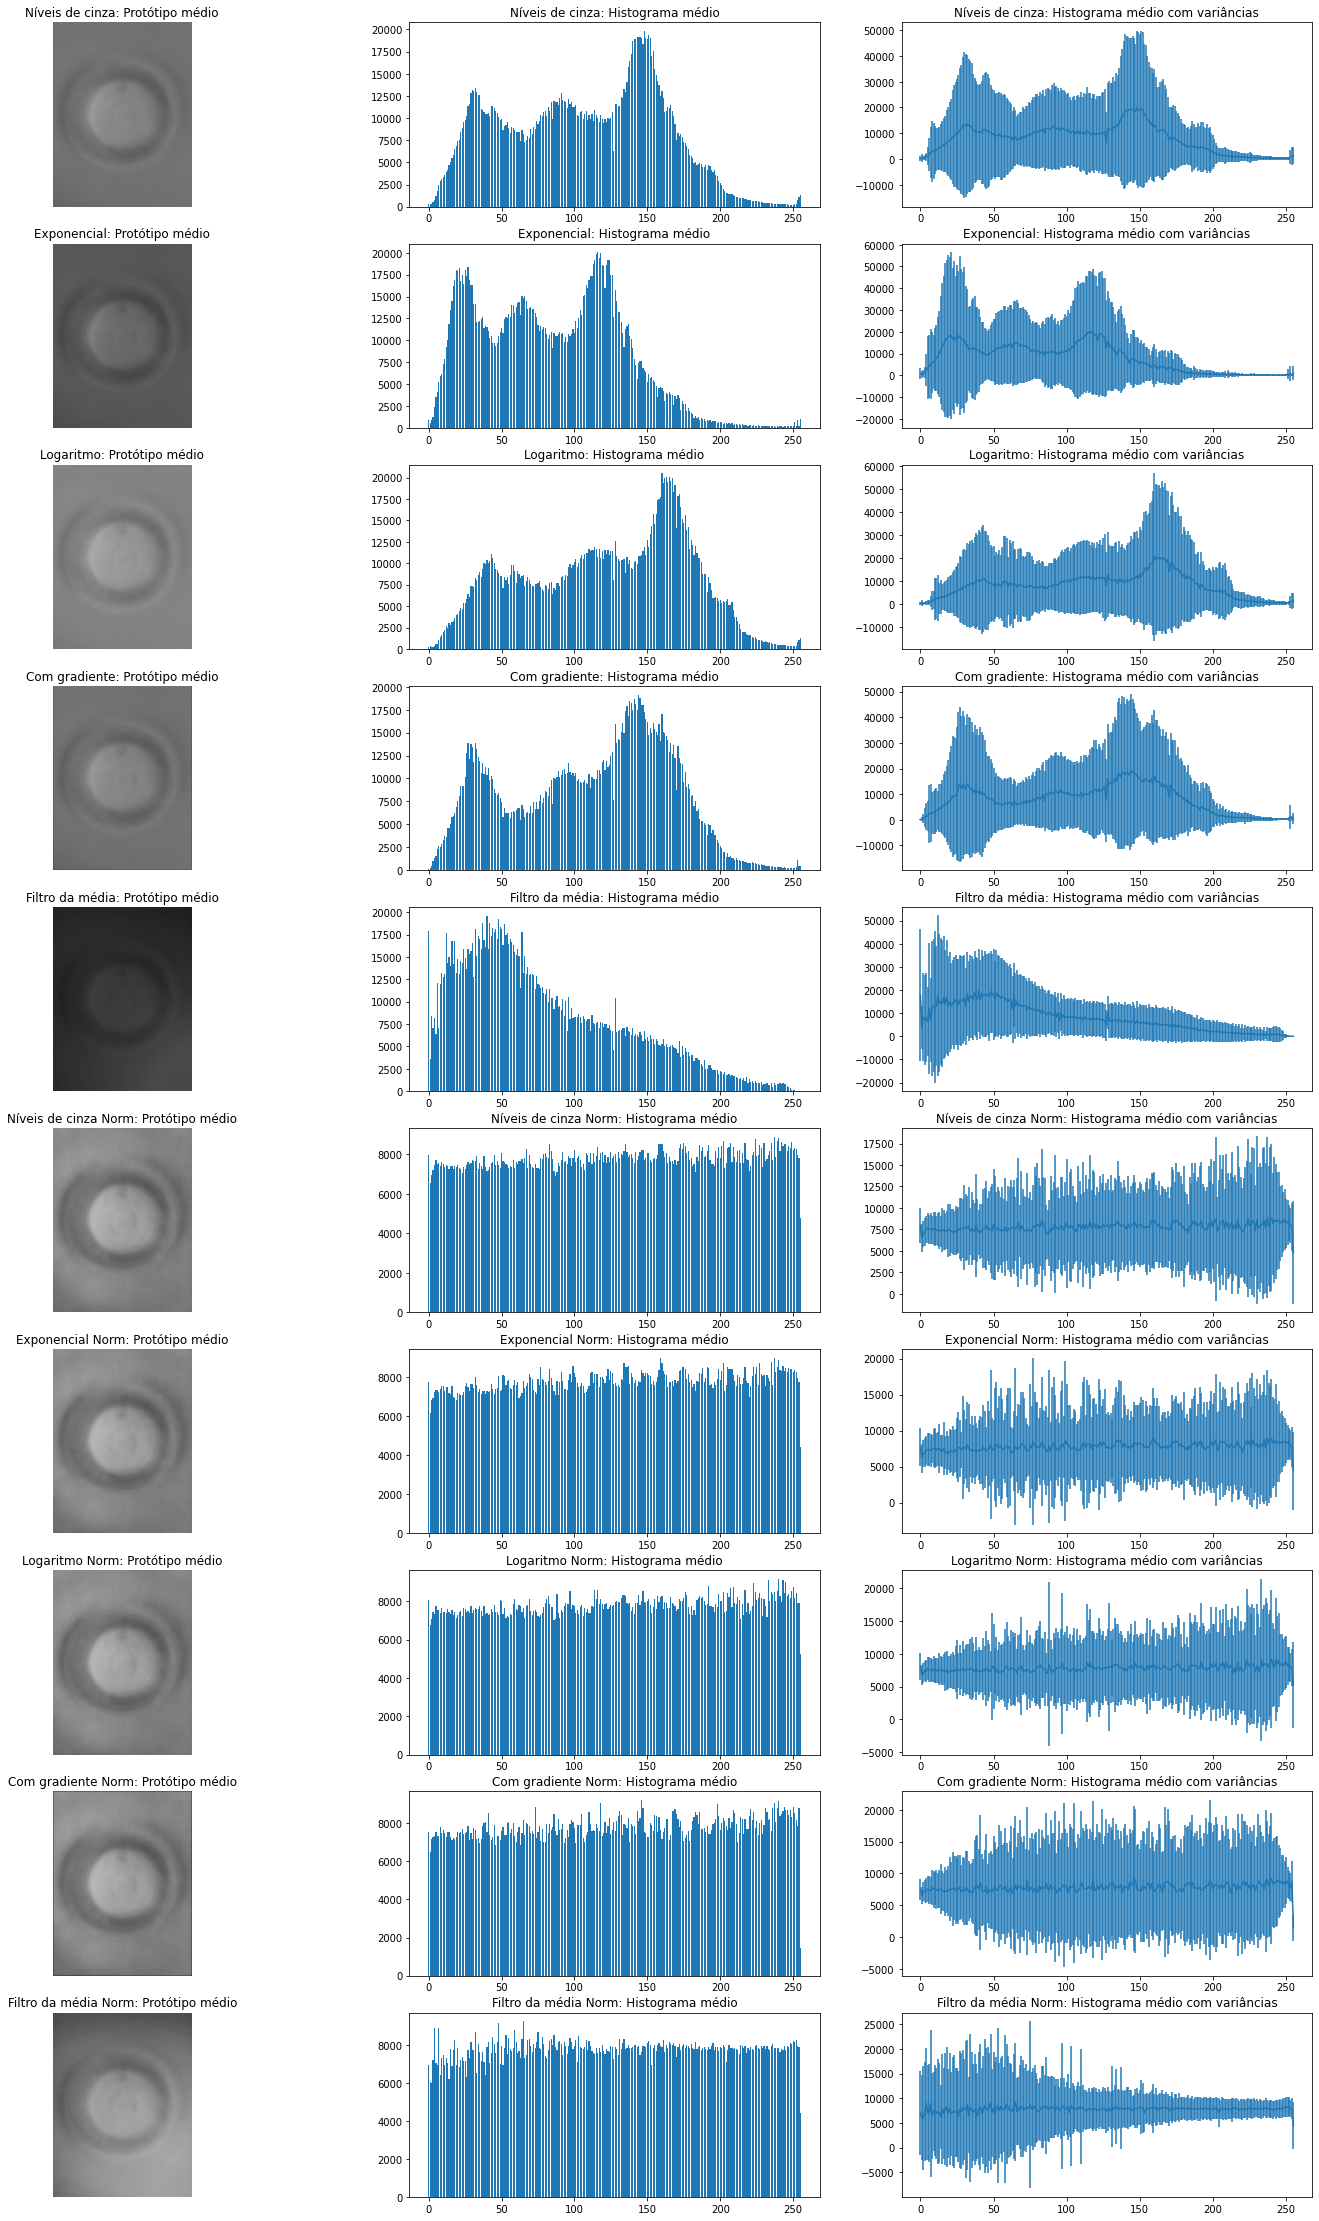

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(prato_prot, prato_hist, prato_var)

* Colher de pau

In [ ]:
cdp_prot, cdp_hist, cdp_var = aplica_protmedio_classe(classe = 'Colher de pau', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Colher de pau: 28.694s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


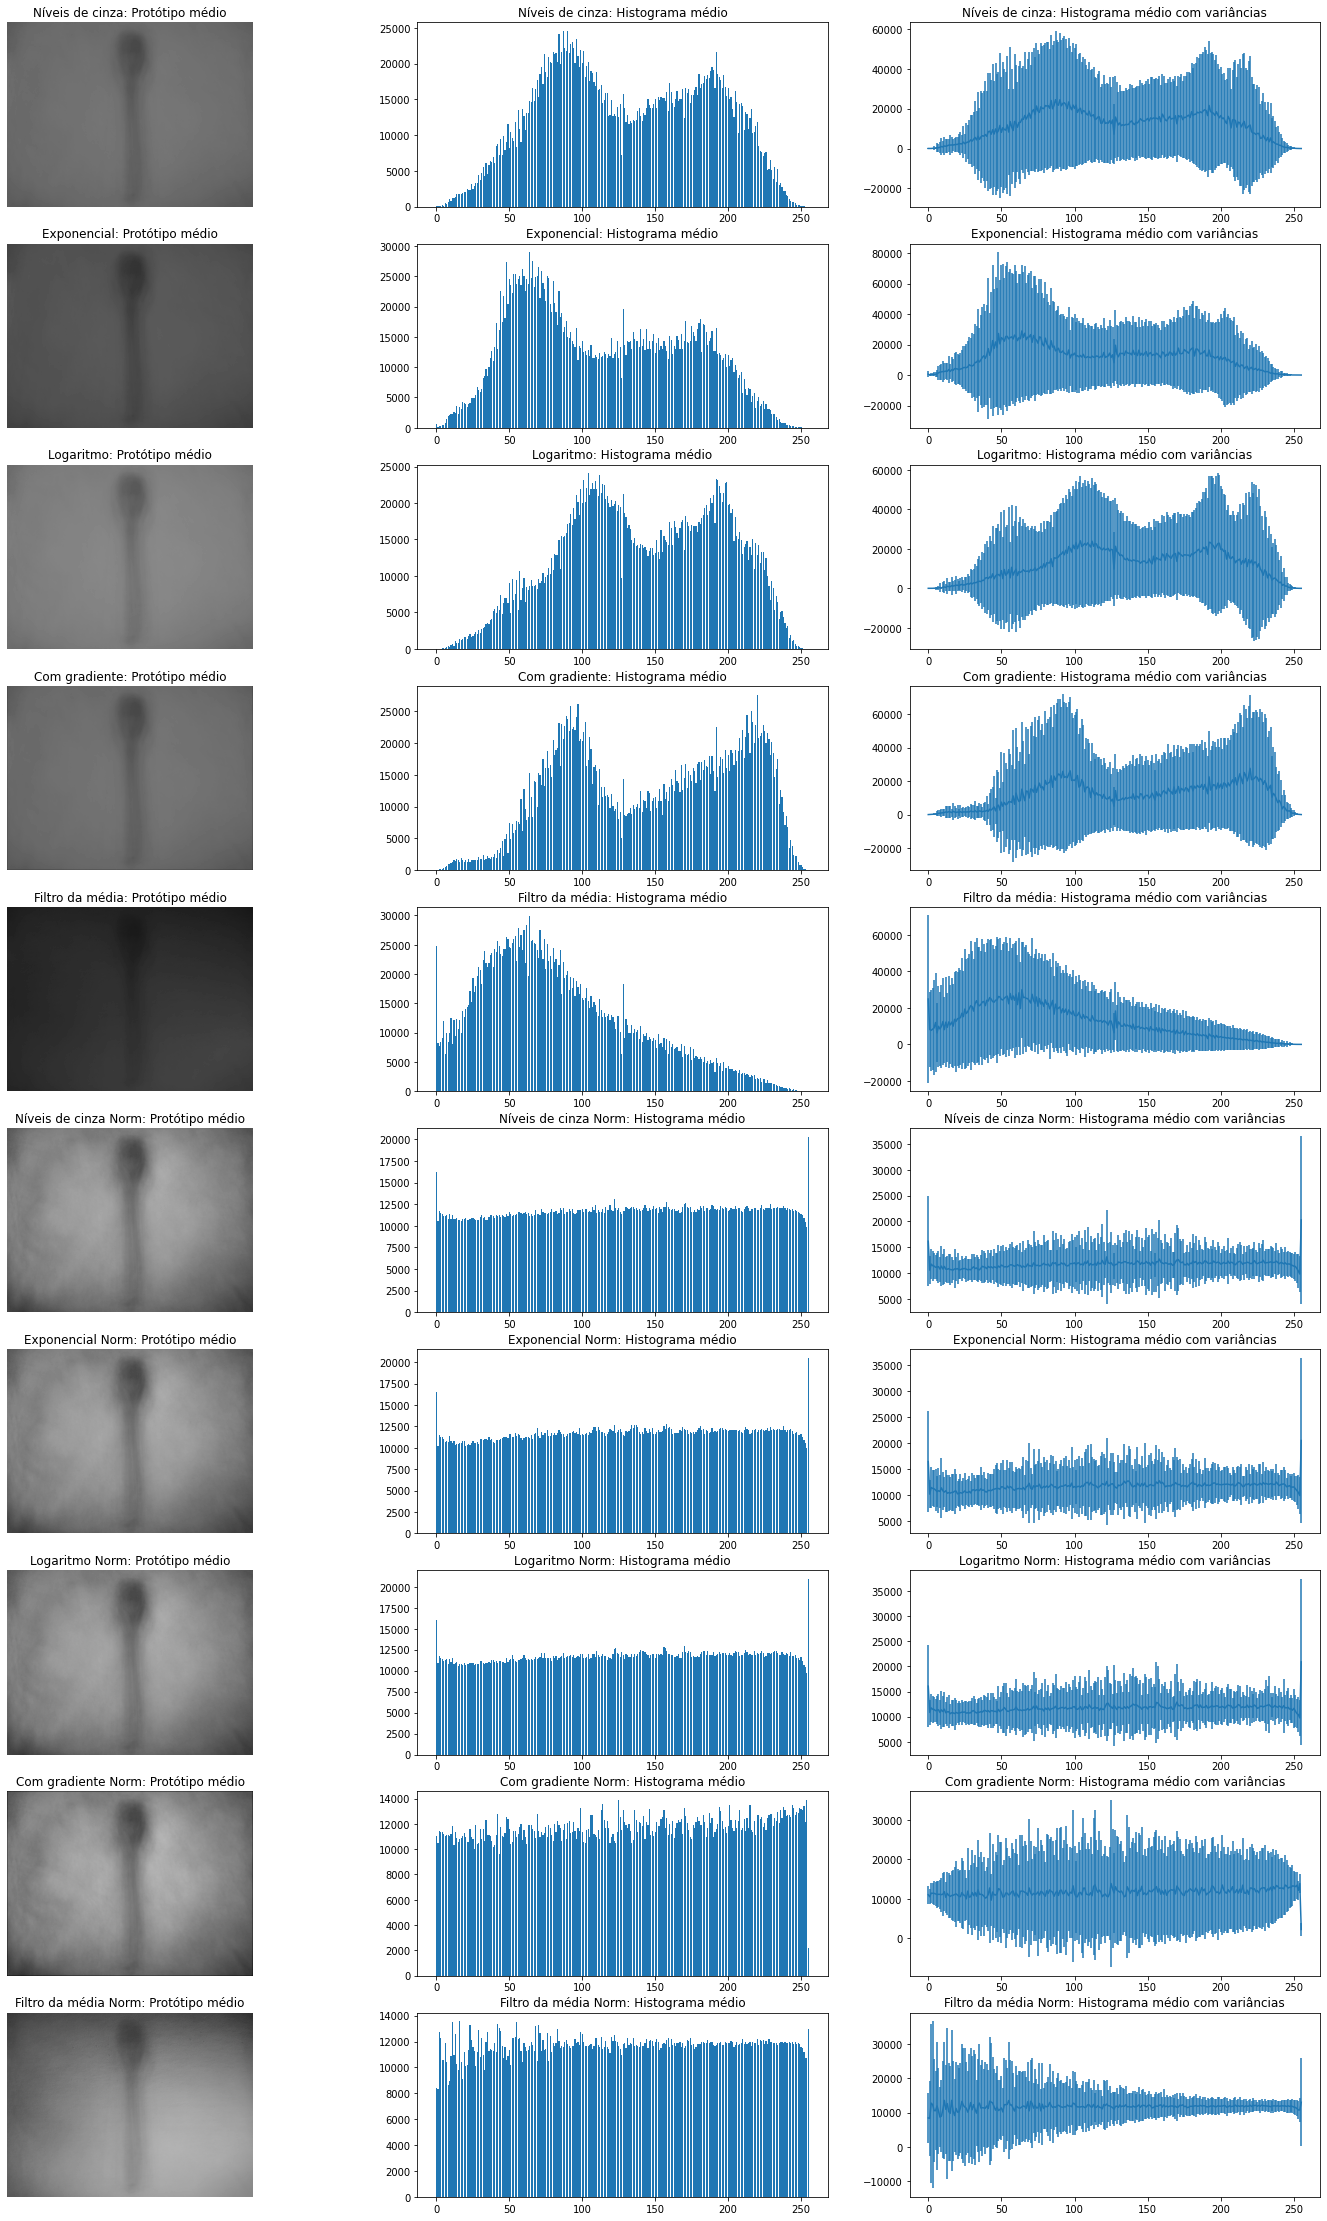

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(cdp_prot, cdp_hist, cdp_var)

* Livro

In [ ]:
livro_prot, livro_hist, livro_var = aplica_protmedio_classe(classe = 'Livro', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Livro: 34.405s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


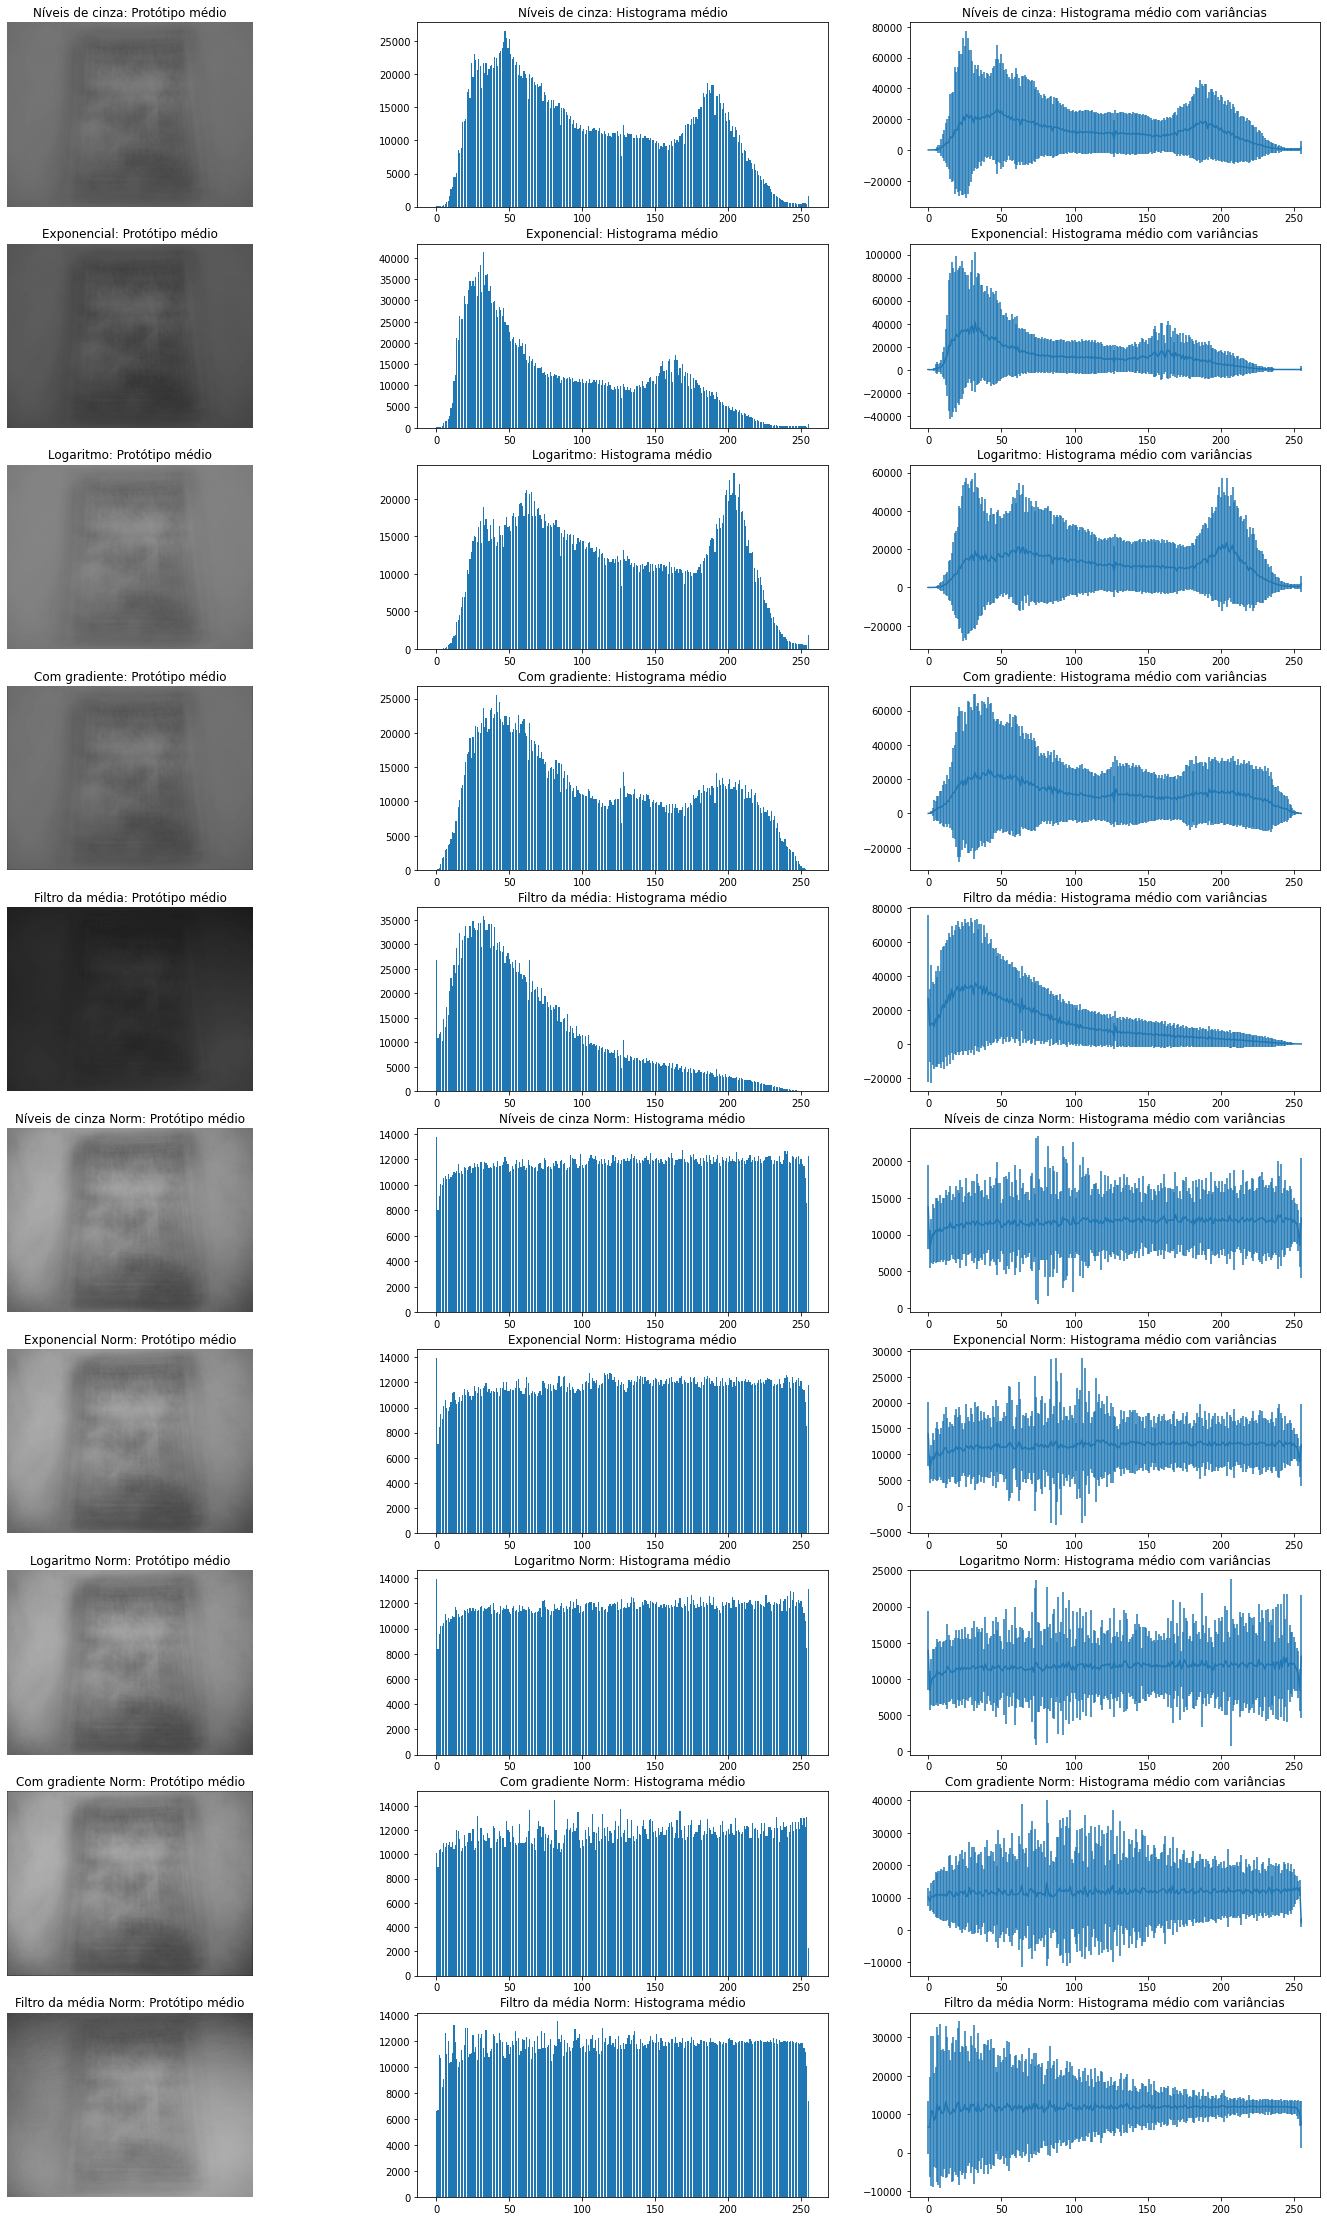

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(livro_prot, livro_hist, livro_var)

* Caneta

In [ ]:
caneta_prot, caneta_hist, caneta_var = aplica_protmedio_classe(classe = 'Caneta', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Caneta: 19.498s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   57.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


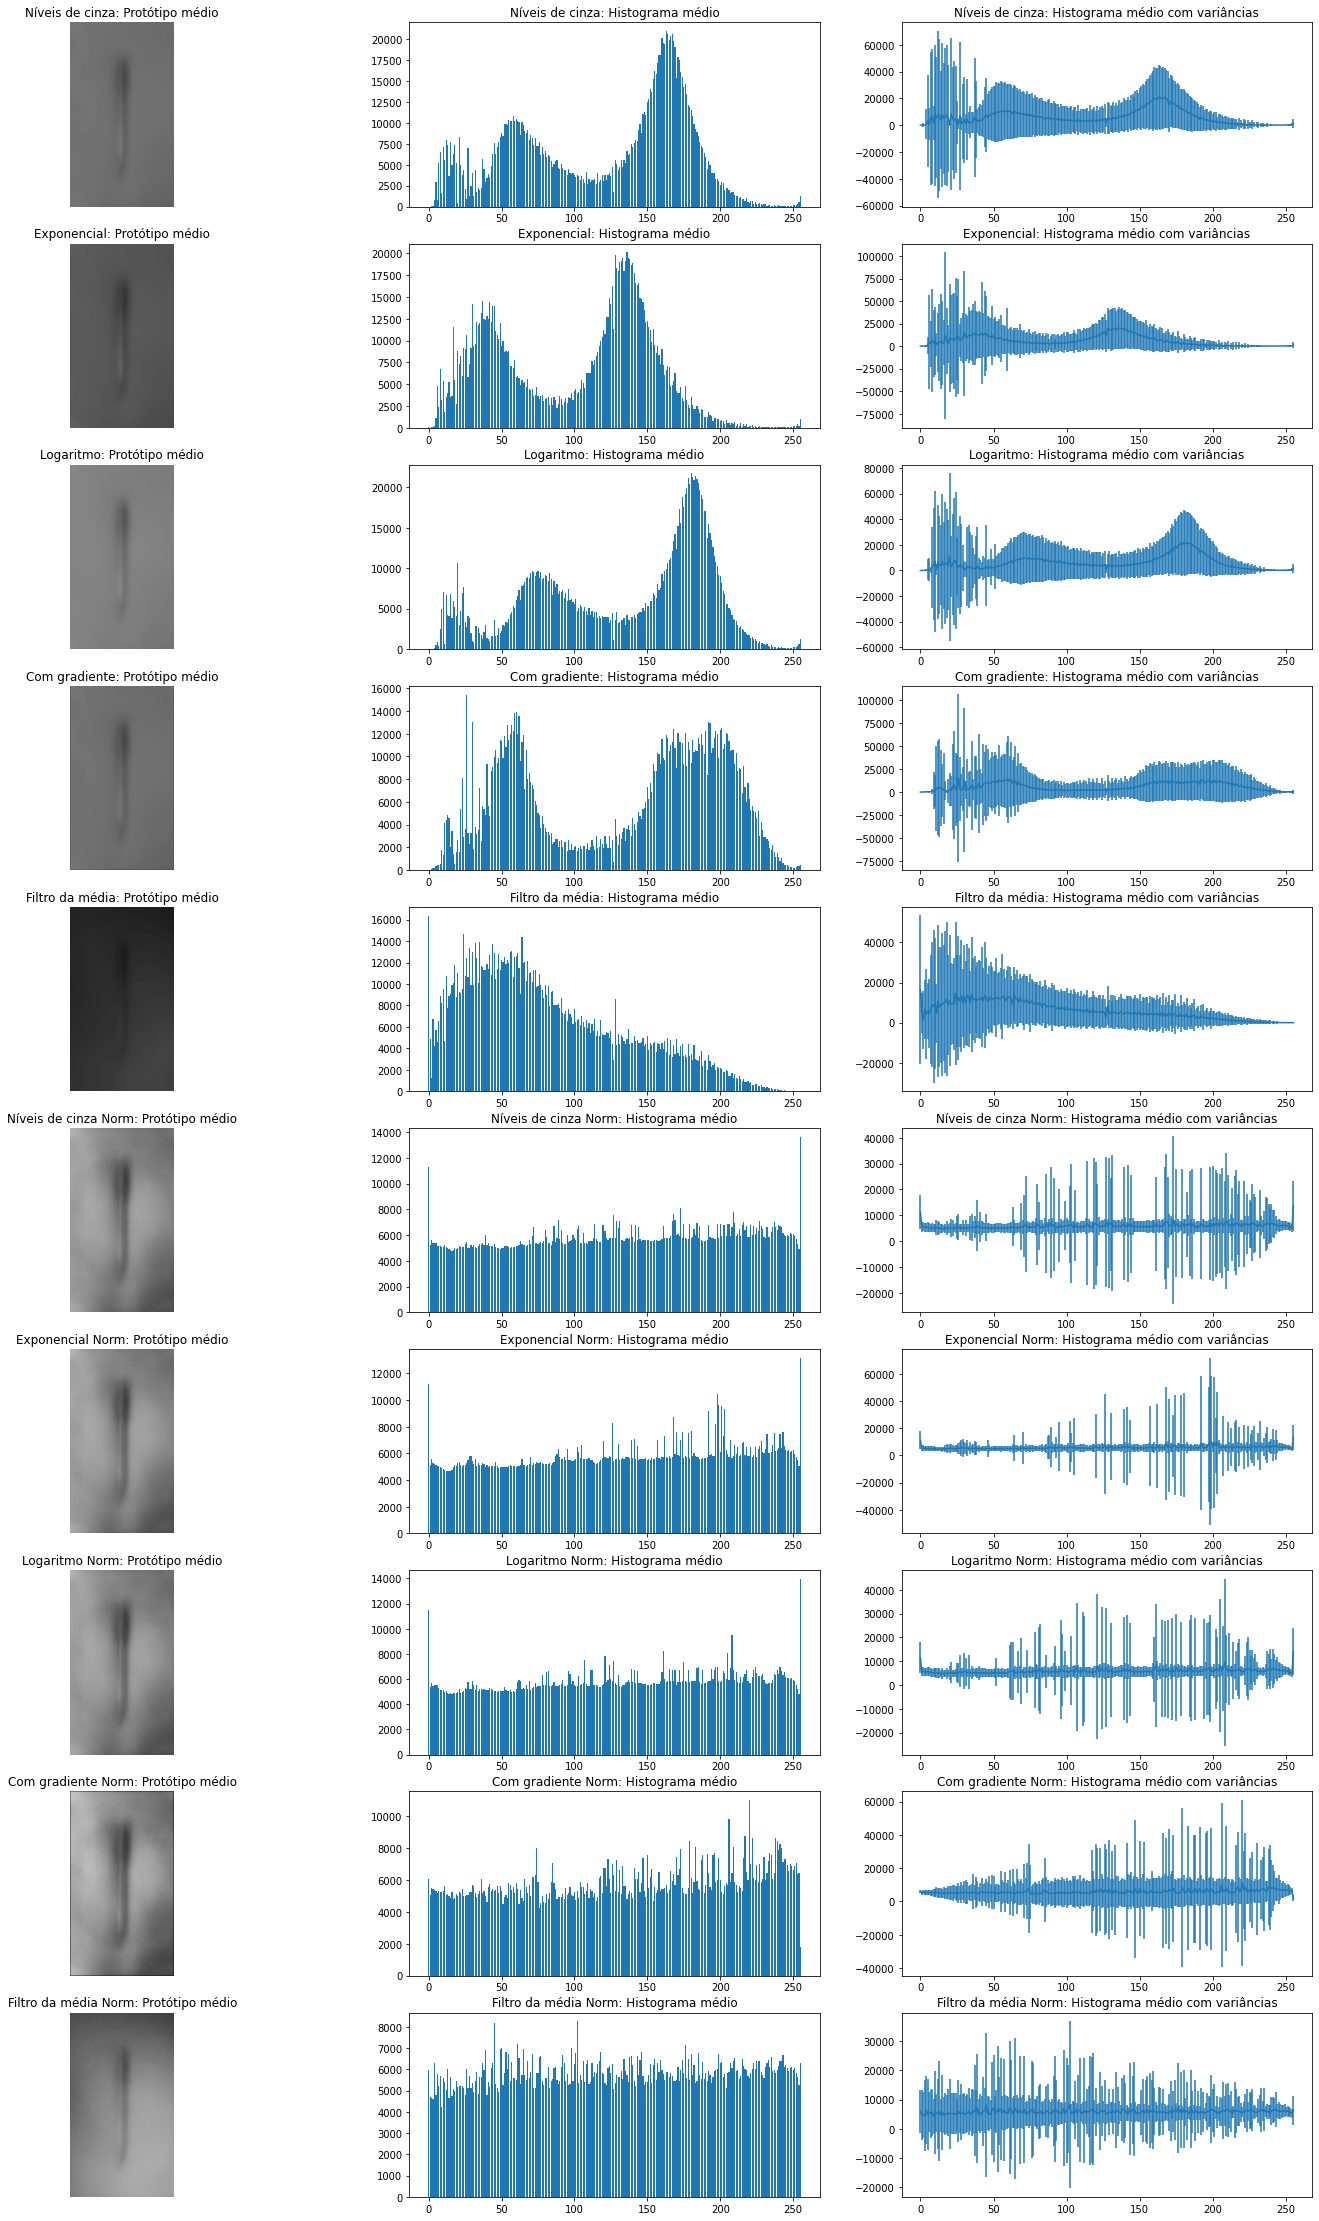

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(caneta_prot, caneta_hist, caneta_var )

* Tênis

In [ ]:
tenis_prot, tenis_hist, tenis_var = aplica_protmedio_classe(classe = 'Tênis', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Tênis: 34.383s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


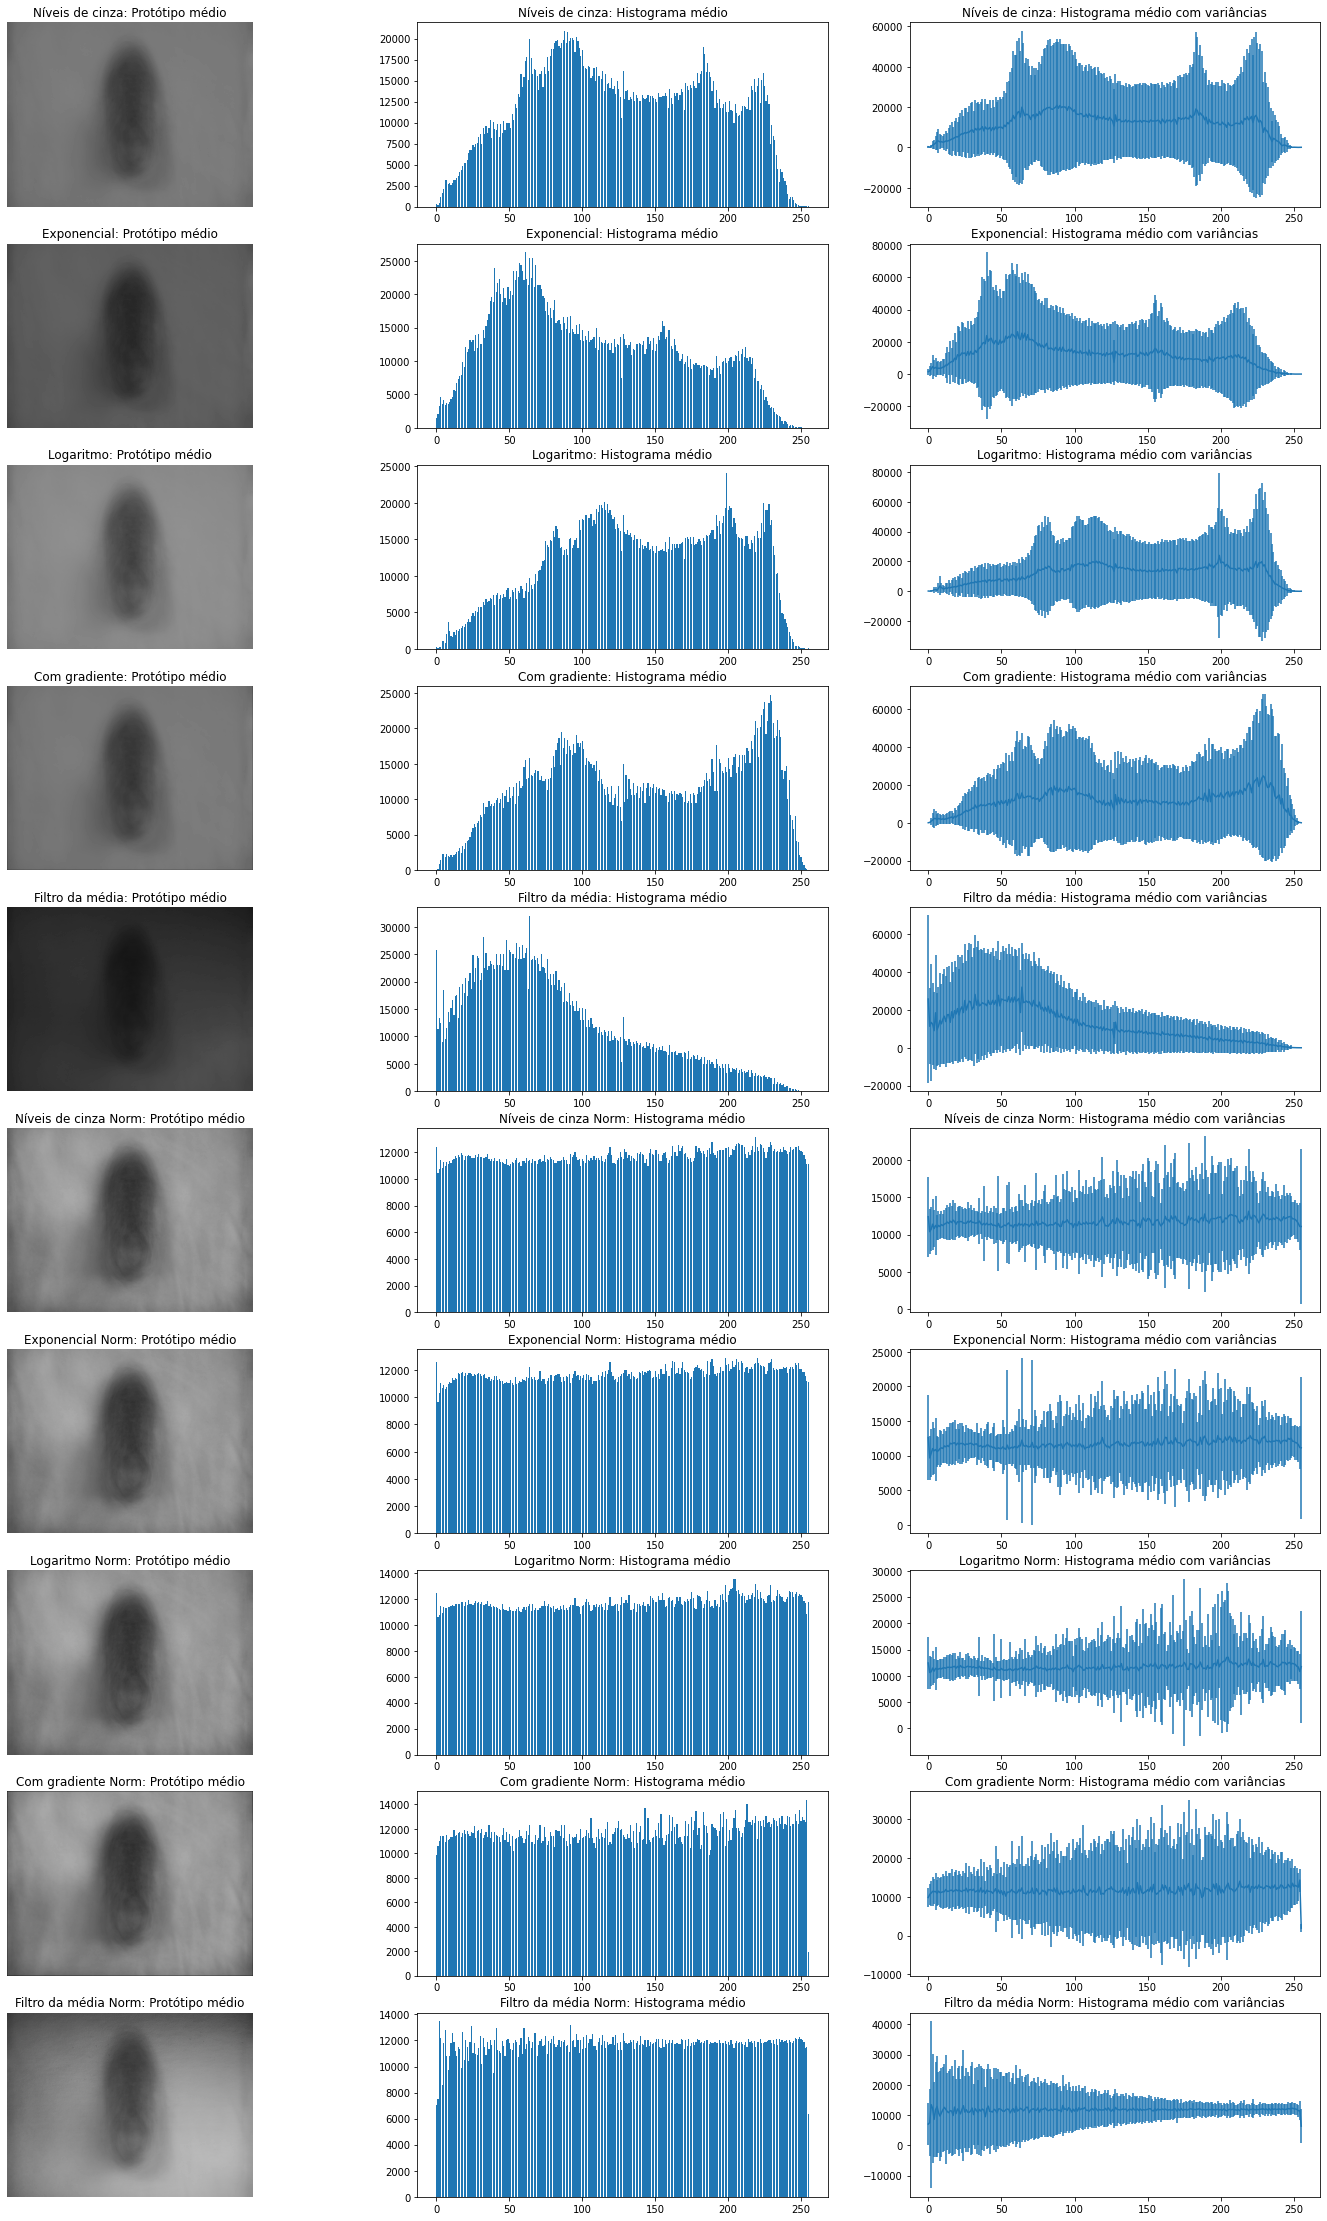

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(tenis_prot, tenis_hist, tenis_var)

* Garfo

In [ ]:
garfo_prot, garfo_hist, garfo_var = aplica_protmedio_classe(classe = 'Garfo', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Garfo: 14.714s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


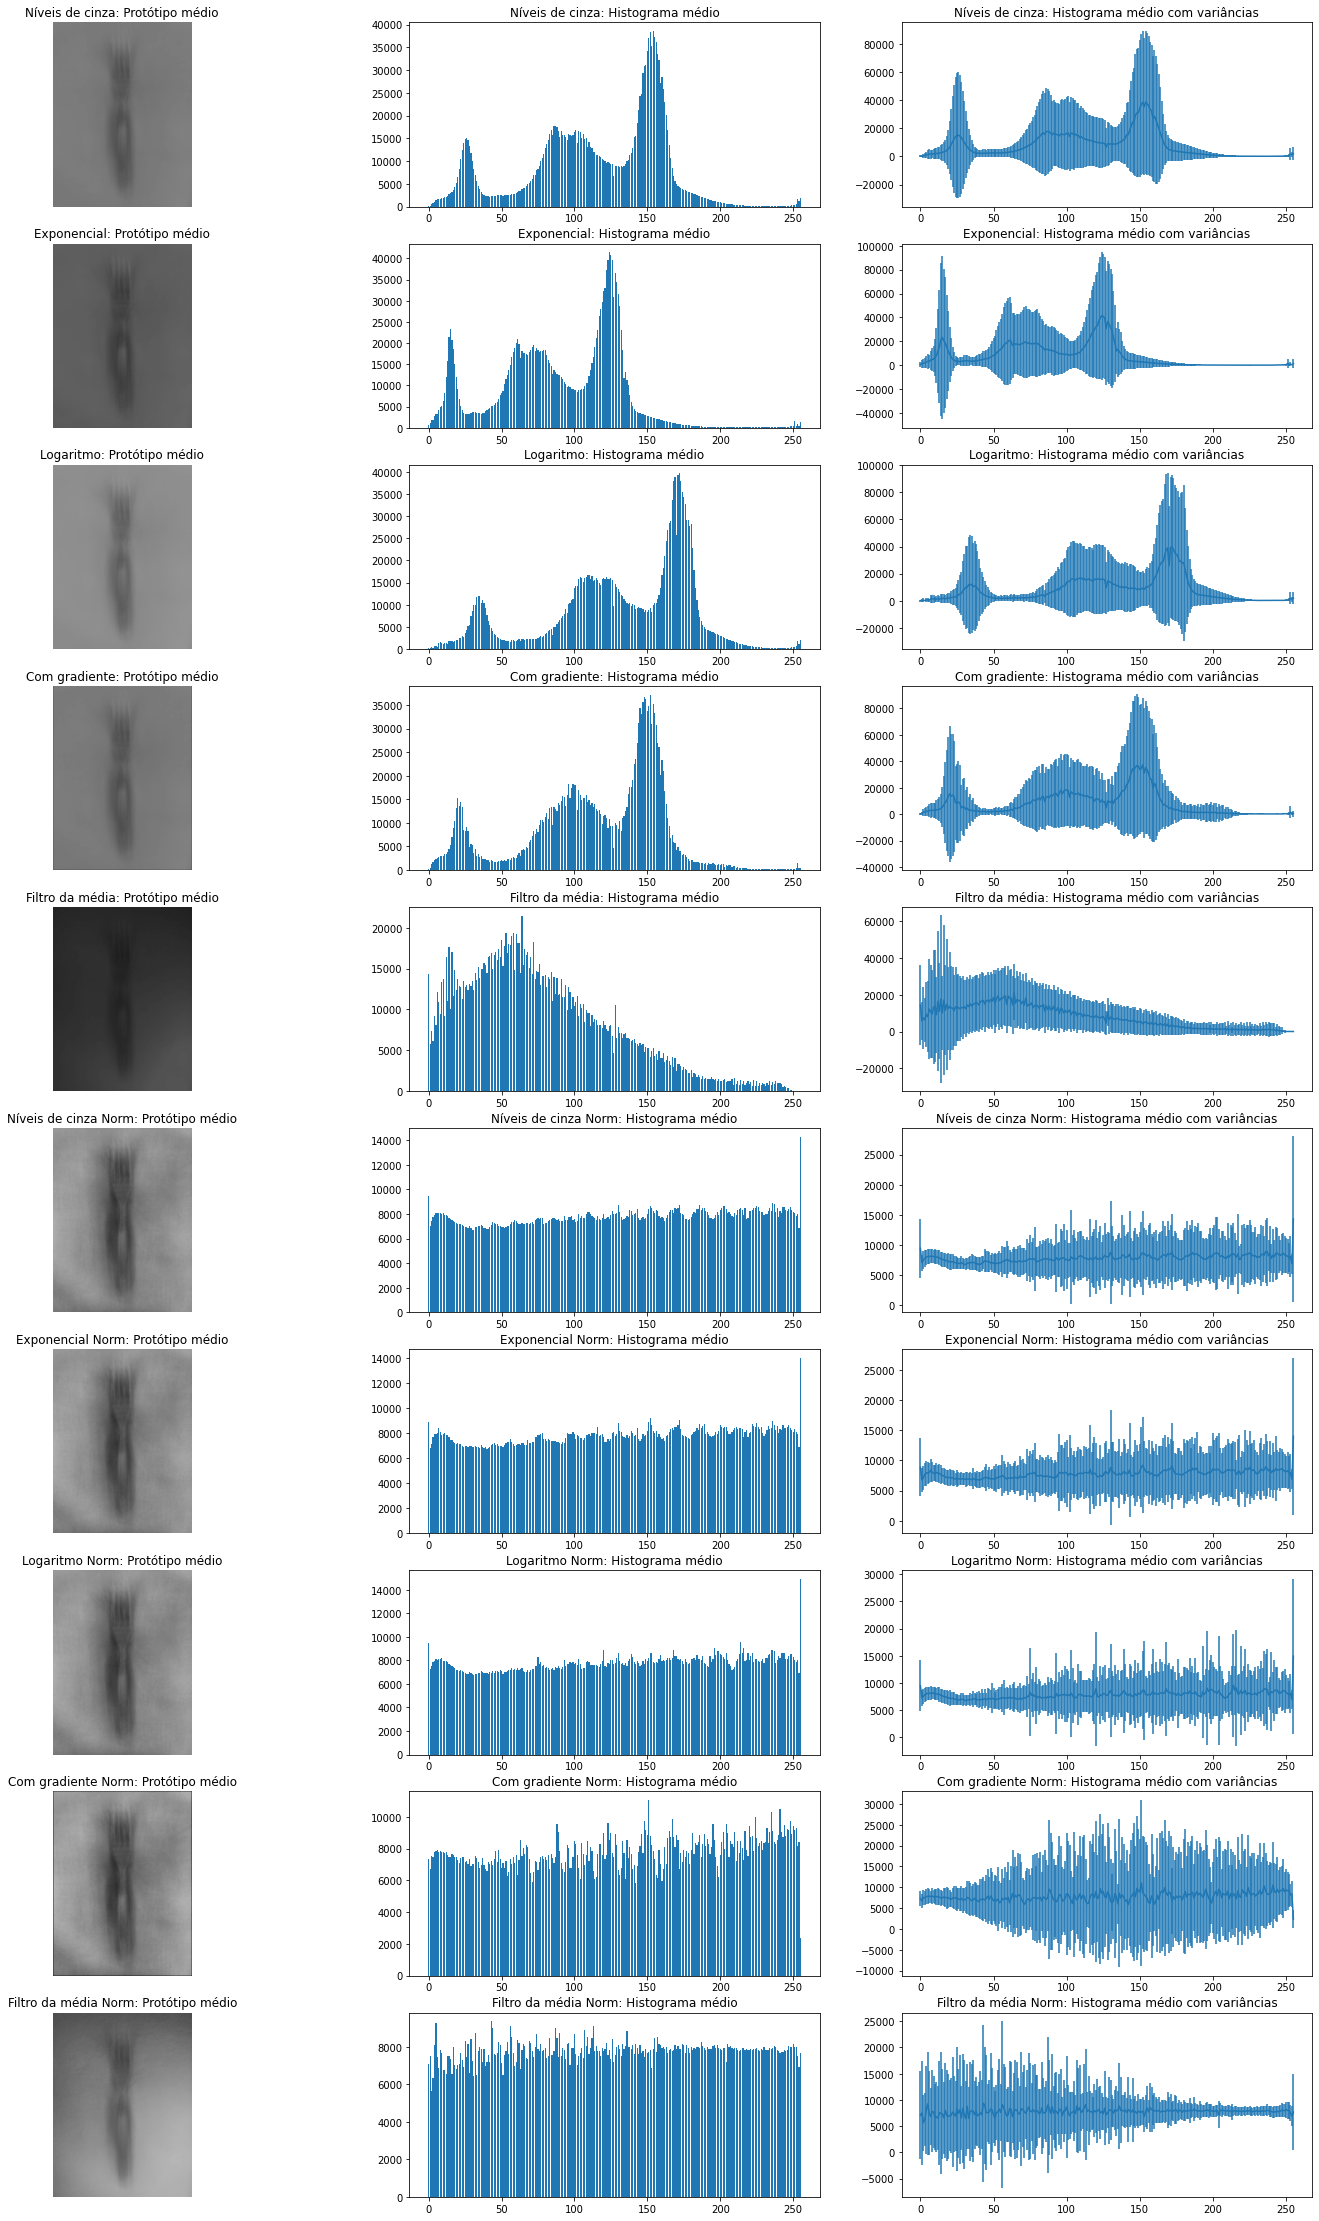

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(garfo_prot, garfo_hist, garfo_var )

* Copo

In [ ]:
copo_prot, copo_hist, copo_var = aplica_protmedio_classe(classe = 'Copo', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Copo: 35.214s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


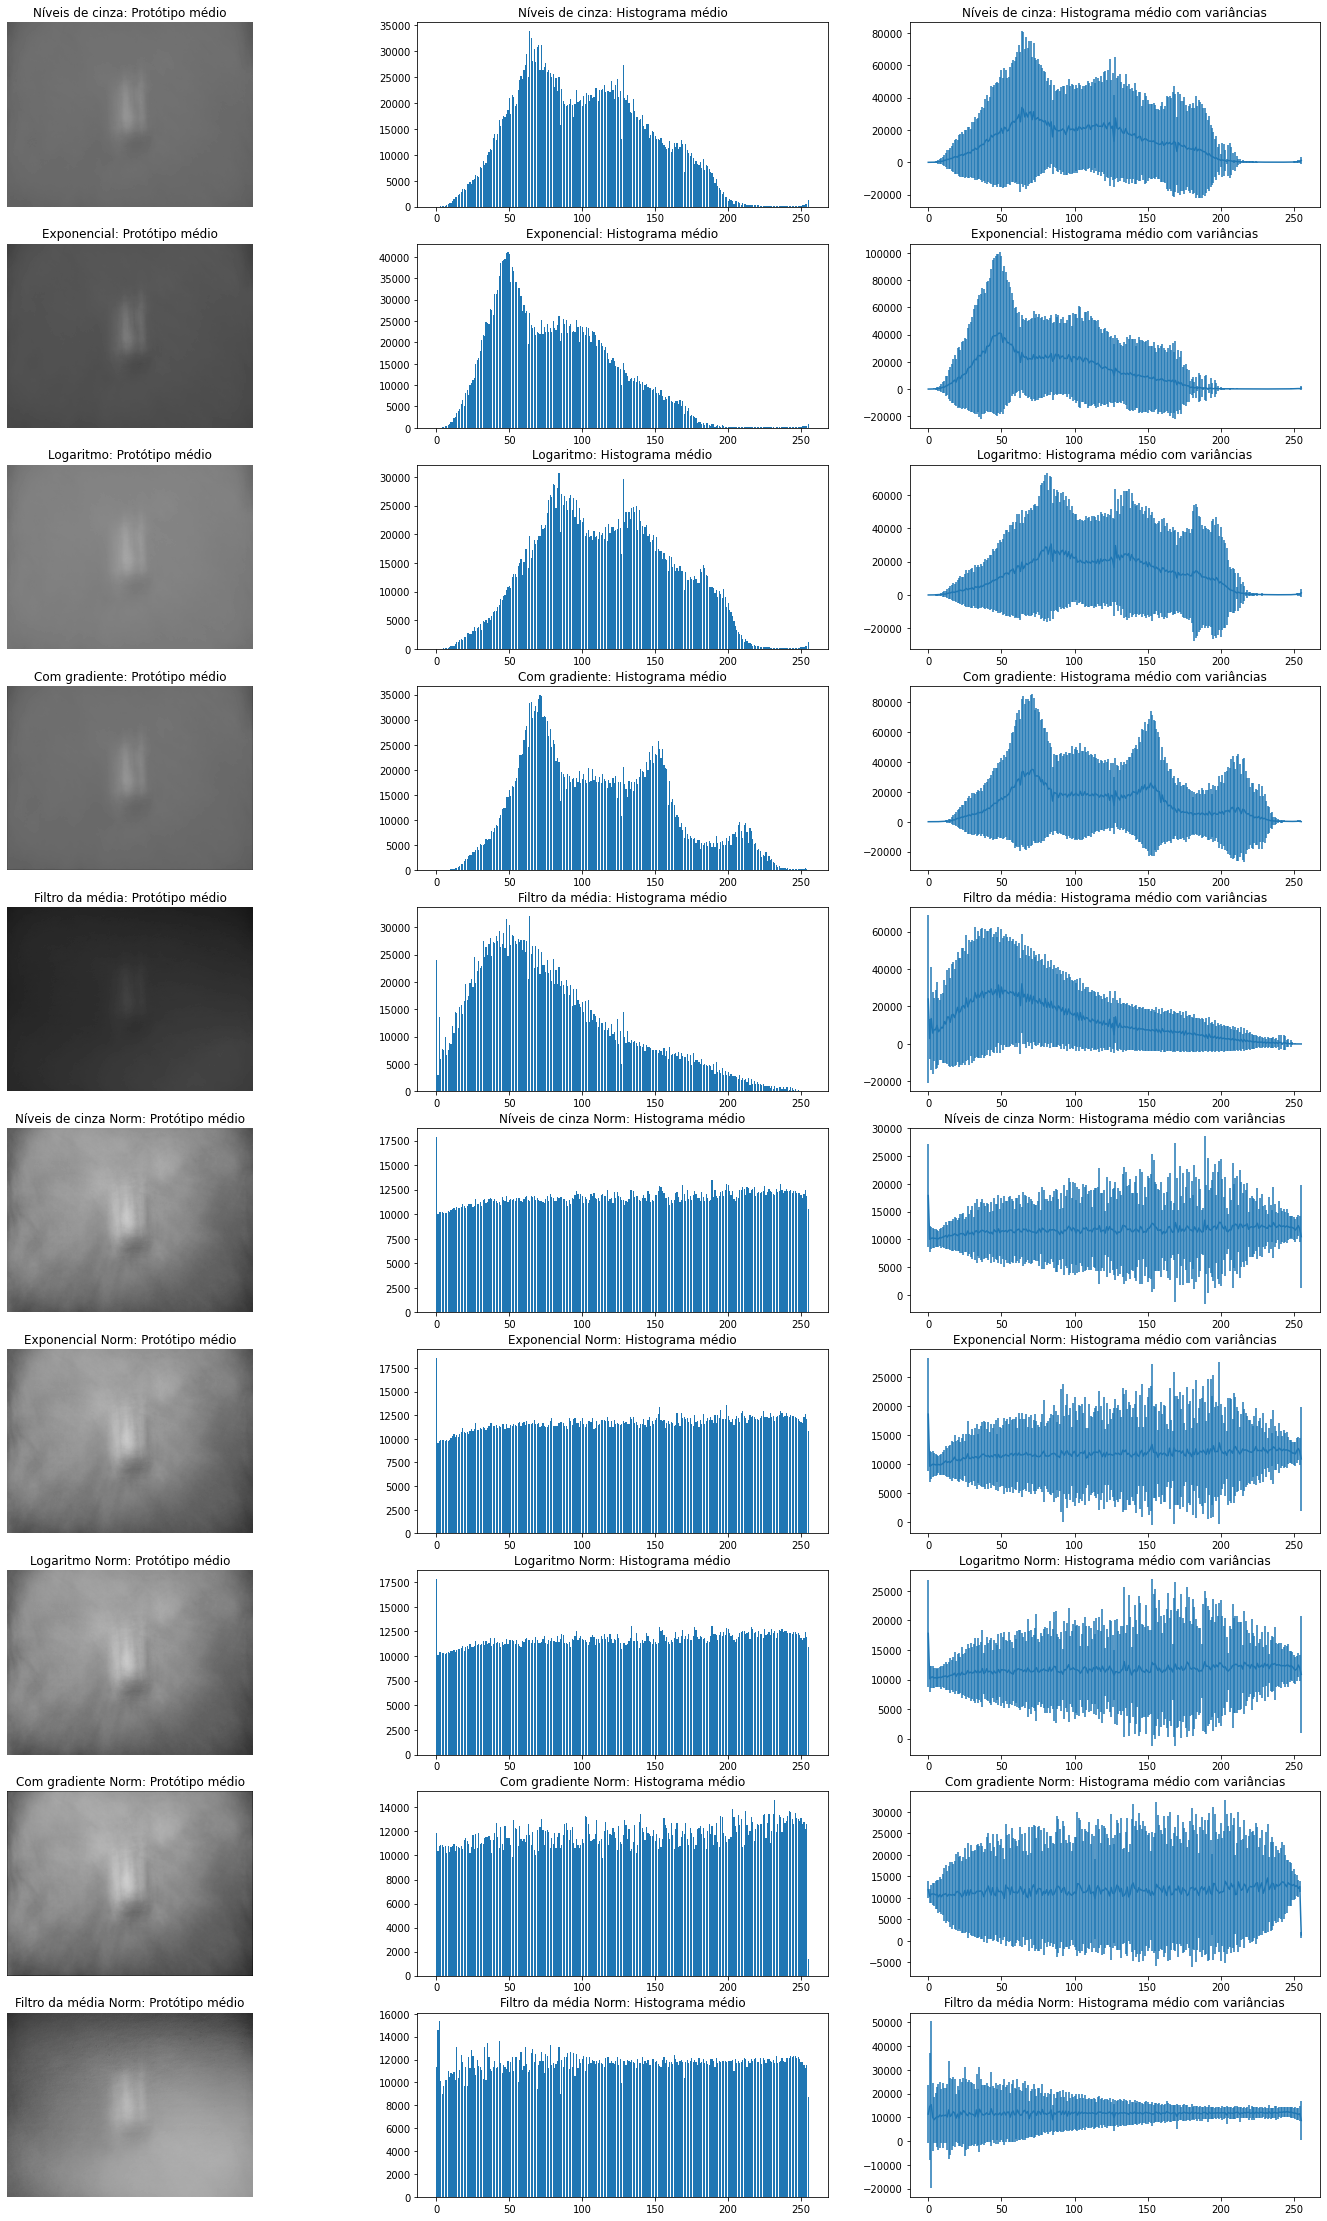

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(copo_prot, copo_hist, copo_var )

* Faca

In [ ]:
faca_prot, faca_hist, faca_var = aplica_protmedio_classe(classe = 'Faca', diretorio = diretorio_final)

Tempo de execução das estatísticas médias para a pasta /content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/Faca: 16.576s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   52.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


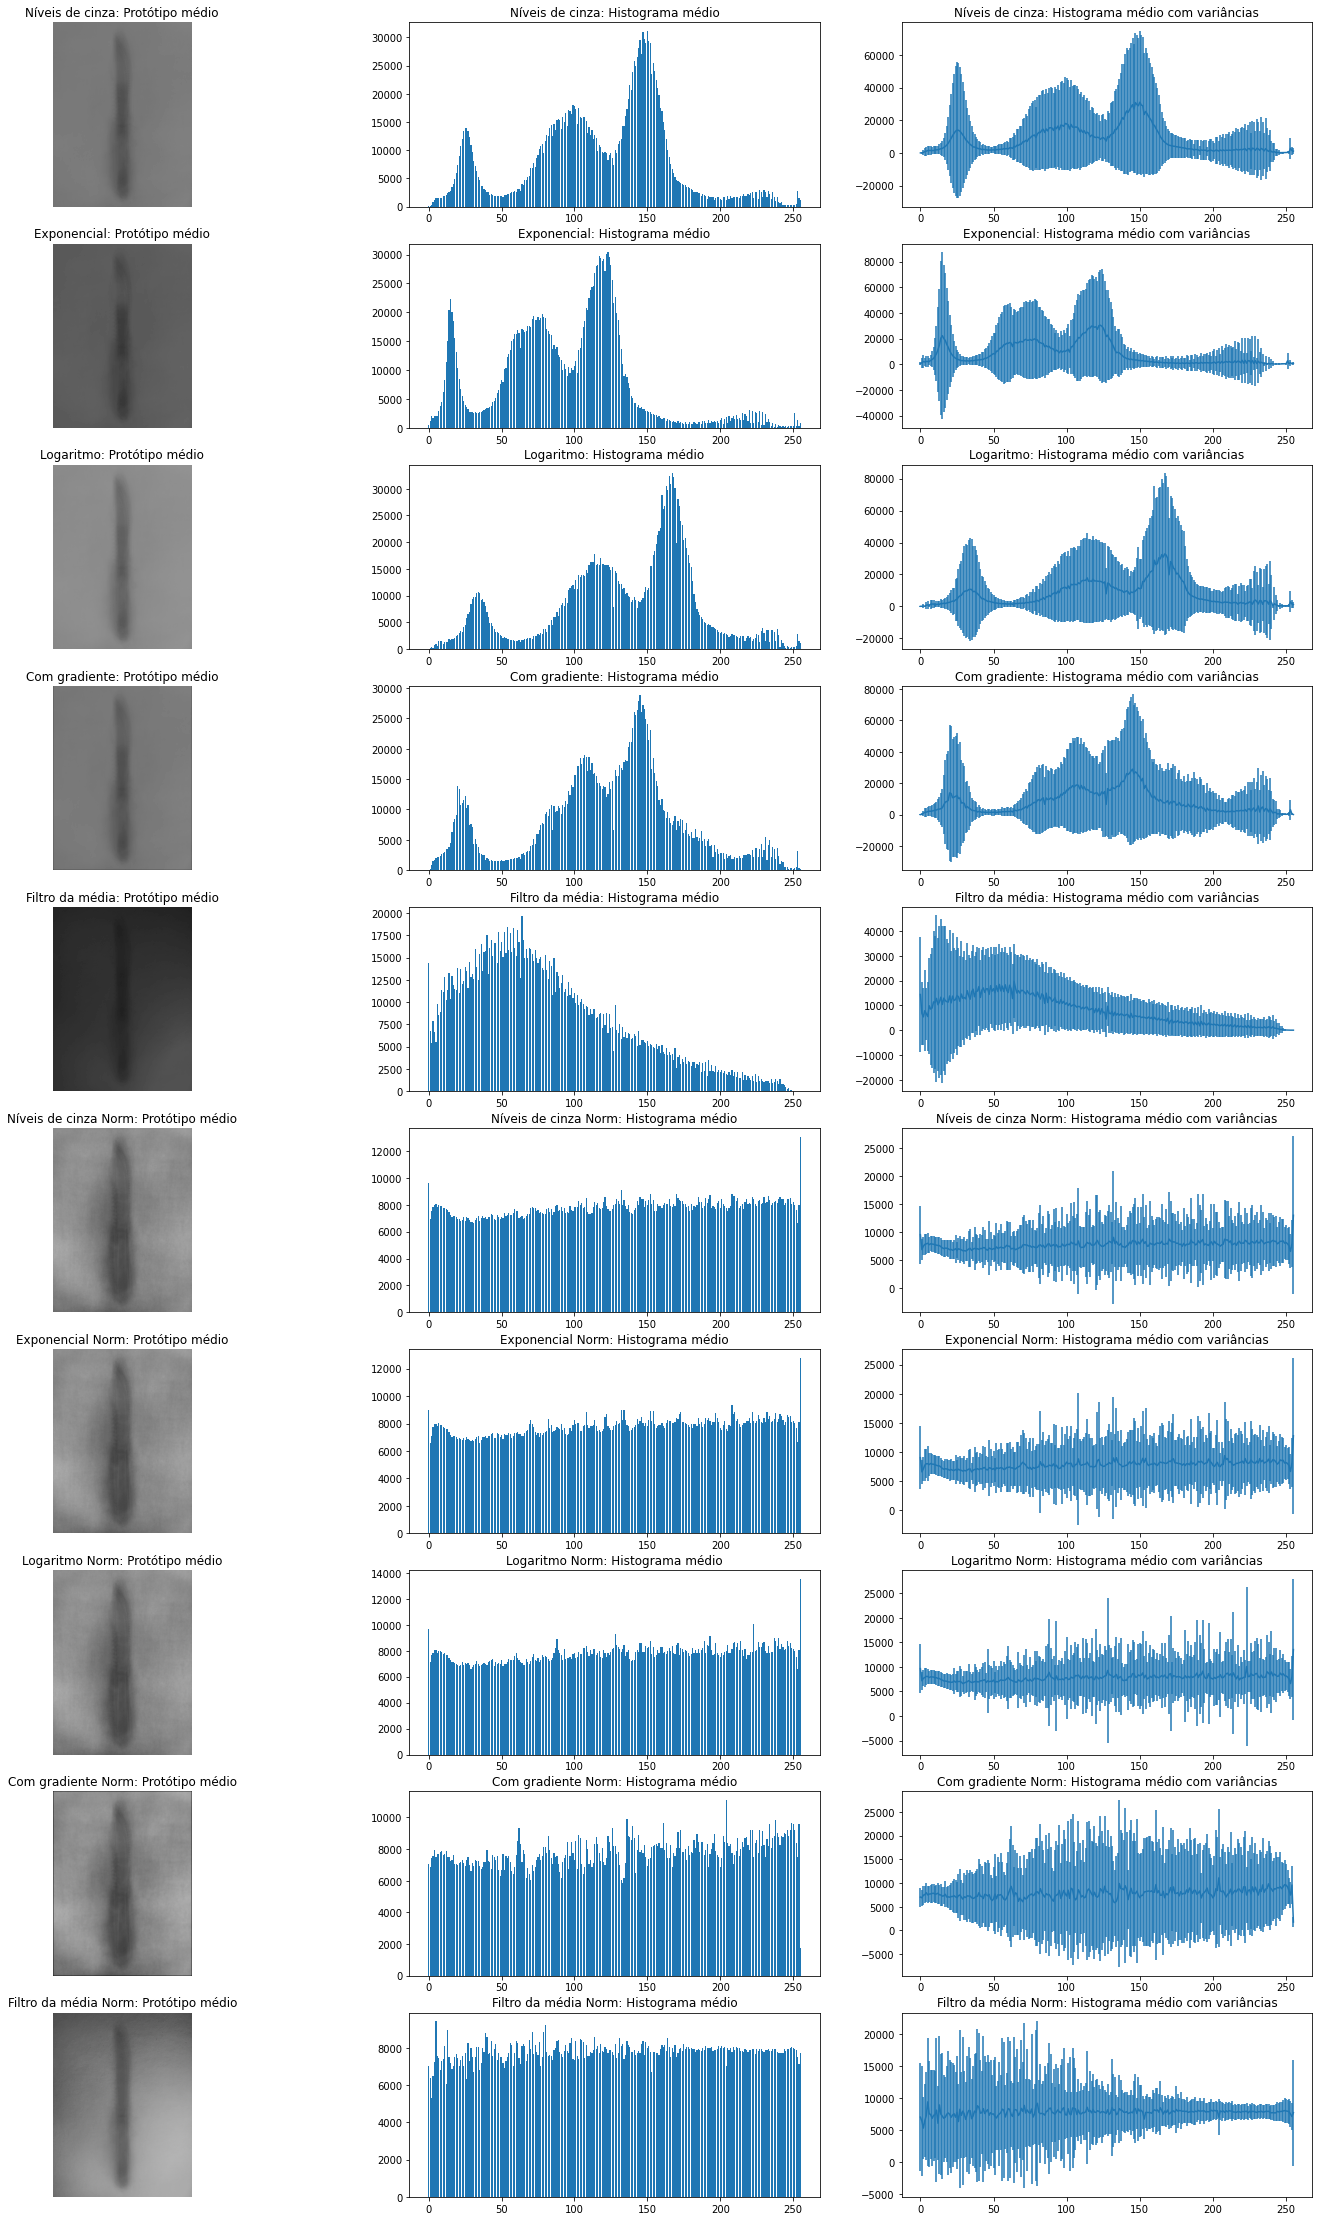

<Figure size 432x288 with 0 Axes>

In [ ]:
grafico(faca_prot, faca_hist, faca_var )

## Tempo de execução do notebook ##

In [ ]:
t11 = time()
tempo_em_horas = (t11-t00)//3600
sobra = (t11-t00)%3600
tempo_em_minutos = sobra//60
tempo_em_segundos = sobra%60
print(f"Tempo de execução do notebook: {tempo_em_horas} h {tempo_em_minutos} min {tempo_em_segundos} s")

Tempo de execução do notebook: 1.0 h 35.0 min 46.59656834602356 s


## 6. Atualização do arquivo de metadados ##


Para a atualização do arquivo de metadados, foram adotados códigos que indicam os tipos de transformação pelos quais cada imagem passou. Esses códigos foram adicionados a uma coluna chamada "transformacao" na folha "Metadados" do arquivo de metadados.

### Transformações:
* org - Imagem colorida original
* cin - Imagem em escala de cinza
* exp - Imagem que passou pela operação exponencial
* grad - Imagem somada a um gradiente de iluminação
* log - Imagem que passou pela operação logaritmica
* med - Imagem que passou pela operação de convolução pelo filtro da média
* norm - Imagem que passou pela operação de normalização de histograma

In [ ]:
# Leitura da tabela contendo os códigos das transformações aplicadas às imagens:
%load_ext google.colab.data_table
transf = pd.read_excel('MetaDadosc.xlsx', sheet_name='Transformacao')
transf

codigo                                          descricao
0    org                           imagem colorida original
1    cin                          imagem em escala de cinza
2    exp        imagem que passou pela operacao exponencial
3   grad         imagem somada a um gradiente de iluminacao
4    log        imagem que passou pela operacao logaritmica
5    med  imagem que passou pela operacao de convolucao ...
6   norm  imagem que passou pela operacao de normalizaca...

In [ ]:
# Geração da lista de arquivos contidos em todas as pastas criadas durante o EP2:

# Lista das pastas que contém os arquivos gerados neste EP:
path_list = ['/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset',
             '/content/gdrive/MyDrive/MAC5768 - EPs/augmentedDataset',
             '/content/gdrive/MyDrive/MAC5768 - EPs/normalizedDataset']

# Laço para gerar a lista de todos os arquivos presentes nas pastas:
img_list = []
for path in path_list:
  for root, dirs, files in os.walk(path):
      for file in files:
          img_list.append(file)

In [ ]:
# Modificação do Data Frame contendo o arquivo de metadados:

# Criação da coluna 'transformacao' e adição do codigo 'org' às imagens originais:
metadados['transformacao'] = 'org'

# Laço para varredura da lista de arquivos:
for img_file in img_list:
  # Captura do tipo de filtro aplicado a imagem:
  img_file_split = img_file[:-4].split('-')
  filtro_nome = '-'.join(img_file_split[1:])
  # Captura do nome original do arquivo:
  img_name = img_file.split('-')[0]
  # Identificando o nome das imagens e copiando a informação correspondente no dataset:
  linha_temp = metadados[metadados['nome_arq'] == img_name]
  # Trocando o nome e guardando na coluna 'transformacao' o sufixo do nome da imagem:
  linha_temp['nome_arq'] = img_file[:-4]
  linha_temp['transformacao'] = filtro_nome
  # Adicionando a nova coluna:
  metadados = metadados.append(linha_temp, ignore_index=True)

In [ ]:
# Escrita do DataFrame novo na aba "metadados" no arquivo de Metadados:

from openpyxl import load_workbook # Import da biblioteca para escrita da nova aba no arquivo existente

book = load_workbook('/content/gdrive/MyDrive/MAC5768 - EPs/MetaDadosc.xlsx') 
writer = pd.ExcelWriter('/content/gdrive/MyDrive/MAC5768 - EPs/MetaDadosc.xlsx', engine='openpyxl') 
writer.book = book

# Listagem das folhas presentes na planilha:
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

# Atribuição da nova folha à planilha:
metadados.to_excel(writer, "Metadados",index=False)

# Escrtia da nova folha na planila:
writer.save()

In [ ]:
%load_ext google.colab.data_table
metadados = pd.read_excel('MetaDadosc.xlsx')
metadados

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


nome_arq  classe  ...  iluminacao  transformacao
0                      lvr1       6  ...           2            org
1                      lvr2       6  ...           2            org
2                      lvr3       6  ...           2            org
3                      lvr4       6  ...           2            org
4                      lvr5       6  ...           2            org
...                     ...     ...  ...         ...            ...
36031  ans356-cin-grad-norm      10  ...           2  cin-grad-norm
36032  ans357-cin-grad-norm      10  ...           2  cin-grad-norm
36033  ans358-cin-grad-norm      10  ...           2  cin-grad-norm
36034  ans359-cin-grad-norm      10  ...           2  cin-grad-norm
36035  ans360-cin-grad-norm      10  ...           2  cin-grad-norm

[36036 rows x 7 columns]